<a href="https://colab.research.google.com/github/felipealbinorodrigues/TCC_PUC/blob/main/Final_TCC_Despesas_Uniao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importação das bibliotecas para uso**


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.stattools as sts 
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
 
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Base de Dados extraída e tratada previamente**

Base de dados Despesas da União (2014 a 2020)

Tratamento do arquivo para abordagem

*fonte*: http://www.portaldatransparencia.gov.br/despesas


In [2]:
despesa_uniao = pd.read_excel('despesas_2014a20.xls', parse_dates=True)

In [ ]:
despesa_uniao.head()

In [4]:
despesa_uniao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20551 entries, 0 to 20550
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   periodo                   20551 non-null  datetime64[ns]
 1   orgao                     20551 non-null  object        
 2   entidade_vinculada_orgao  20551 non-null  object        
 3   vl_pago                   20551 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 642.3+ KB


In [5]:
despesa_uniao.dtypes

periodo                     datetime64[ns]
orgao                               object
entidade_vinculada_orgao            object
vl_pago                            float64
dtype: object

In [6]:
df_desp = despesa_uniao

In [7]:
df_desp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20551 entries, 0 to 20550
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   periodo                   20551 non-null  datetime64[ns]
 1   orgao                     20551 non-null  object        
 2   entidade_vinculada_orgao  20551 non-null  object        
 3   vl_pago                   20551 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 642.3+ KB


**Agrupando as "Entidades" por "orgao"/Ministério**


In [8]:

df_result = df_desp.groupby(['periodo', 'orgao'])['vl_pago'].sum()

In [9]:
df_result

periodo     orgao                                                              
2014-01-01  20000 - Presidência da República                                       6.519071e+07
            20113 - Ministério do Planejamento, Desenvolvimento e Gestão           6.115671e+06
            22000 - Ministério da Agricultura, Pecuária e Abastecimento            6.272410e+08
            24000 - Ministério da Ciência, Tecnologia, Inovações e Comunicações    7.881719e+08
            25000 - Ministério da Economia                                         2.307079e+11
                                                                                       ...     
2020-12-01  53000 - Ministério do Desenvolvimento Regional                         4.035312e+09
            54000 - Ministério do Turismo                                          1.805339e+09
            55000 - Ministério da Cidadania                                        3.453721e+10
            63000 - Advocacia-Geral da União            

In [10]:
type(df_result)

pandas.core.series.Series

In [11]:
df_result2 = pd.DataFrame(df_result)

In [12]:
df_result2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1927 entries, (Timestamp('2014-01-01 00:00:00'), '20000 - Presidência da República') to (Timestamp('2020-12-01 00:00:00'), '81000 - Ministério da Mulher, Família e Direitos Humanos')
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   vl_pago  1927 non-null   float64
dtypes: float64(1)
memory usage: 19.8+ KB


In [13]:
df_result2.reset_index()

periodo  ...       vl_pago
0    2014-01-01  ...  6.519071e+07
1    2014-01-01  ...  6.115671e+06
2    2014-01-01  ...  6.272410e+08
3    2014-01-01  ...  7.881719e+08
4    2014-01-01  ...  2.307079e+11
...         ...  ...           ...
1922 2020-12-01  ...  4.035312e+09
1923 2020-12-01  ...  1.805339e+09
1924 2020-12-01  ...  3.453721e+10
1925 2020-12-01  ...  3.854883e+08
1926 2020-12-01  ...  2.592352e+07

[1927 rows x 3 columns]

In [14]:
df_result2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1927 entries, (Timestamp('2014-01-01 00:00:00'), '20000 - Presidência da República') to (Timestamp('2020-12-01 00:00:00'), '81000 - Ministério da Mulher, Família e Direitos Humanos')
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   vl_pago  1927 non-null   float64
dtypes: float64(1)
memory usage: 19.8+ KB


**Transformando os Ministérios em colunas para melhor tratamento**

In [15]:
df_result3 = df_result2.pivot_table('vl_pago', 'periodo', 'orgao')

In [16]:
df_result3.head()

orgao       20000 - Presidência da República  ...  81000 - Ministério da Mulher, Família e Direitos Humanos
periodo                                       ...                                                          
2014-01-01                      6.519071e+07  ...                                          173057.83       
2014-02-01                      8.479716e+07  ...                                          274031.03       
2014-03-01                      8.807581e+07  ...                                          943347.53       
2014-04-01                      1.130643e+08  ...                                          830892.75       
2014-05-01                      1.147648e+08  ...                                          500151.37       

[5 rows x 28 columns]

In [17]:
df_result3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2014-01-01 to 2020-12-01
Data columns (total 28 columns):
 #   Column                                                                                  Non-Null Count  Dtype  
---  ------                                                                                  --------------  -----  
 0   20000 - Presidência da República                                                        84 non-null     float64
 1   20113 - Ministério do Planejamento, Desenvolvimento e Gestão                            45 non-null     float64
 2   22000 - Ministério da Agricultura, Pecuária e Abastecimento                             84 non-null     float64
 3   24000 - Ministério da Ciência, Tecnologia, Inovações e Comunicações                     84 non-null     float64
 4   25000 - Ministério da Economia                                                          84 non-null     float64
 5   26000 - Ministério da Educação                       

Cria-se lista com todos os Ministérios (coluna "orgao"), facilitando o histórico de Despesas desde 2014

In [18]:
gastos = [x for x in df_result3]

A plotagem é inicial, apenas para compreender o cenário de gastos por Ministério da União

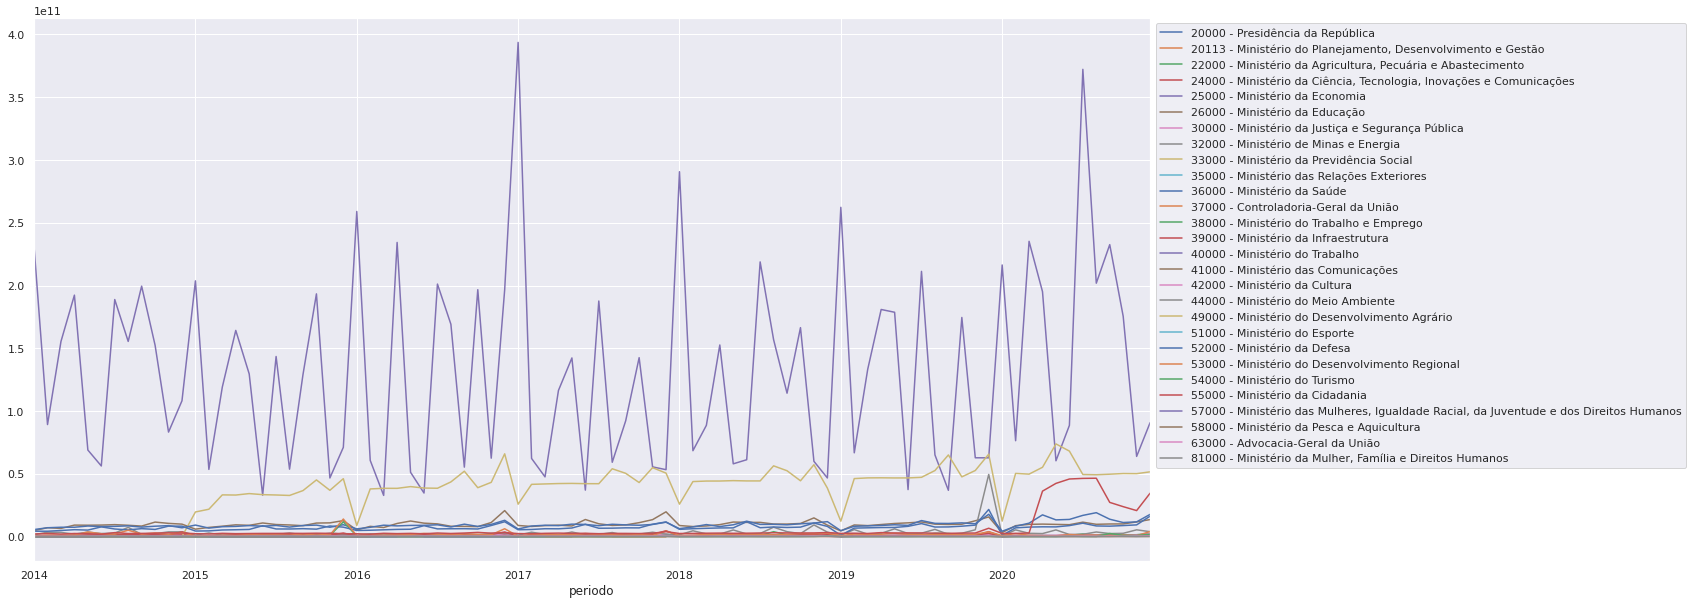

In [19]:
ax = df_result3.plot(figsize = (20,10))
ax.legend(loc=0, bbox_to_anchor=(1.0,1.0));

É latente observar que o Ministério da Economia é o órgão que mais "gasta" dentro do orçamento da União. A partir disso, vamos listar os Ministérios que mais geram despesas para a União por ranking, facilitando algumas observações futuras

In [20]:
total = {}

for i in df_result3:
  total[i] = df_result3[i].sum()

In [21]:
total

{'20000 - Presidência da República': 12443979478.76,
 '20113 - Ministério do Planejamento, Desenvolvimento e Gestão': 61424735.379999995,
 '22000 - Ministério da Agricultura, Pecuária e Abastecimento': 103959278832.75,
 '24000 - Ministério da Ciência, Tecnologia, Inovações e Comunicações': 60327380333.450005,
 '25000 - Ministério da Economia': 10929667012389.3,
 '26000 - Ministério da Educação': 831551580398.22,
 '30000 - Ministério da Justiça e Segurança Pública': 83861908140.51,
 '32000 - Ministério de Minas e Energia': 280308751114.8,
 '33000 - Ministério da Previdência Social': 3149112994569.6396,
 '35000 - Ministério das Relações Exteriores': 23694826964.620003,
 '36000 - Ministério da Saúde': 803468112167.6101,
 '37000 - Controladoria-Geral da União': 6387952507.239999,
 '38000 - Ministério do Trabalho e Emprego': 21256005350.36,
 '39000 - Ministério da Infraestrutura': 100227376618.17003,
 '40000 - Ministério do Trabalho': 4732231.68,
 '41000 - Ministério das Comunicações': 5795

In [22]:
total_pd = pd.DataFrame.from_dict(total, orient='index', columns=['TOTAL'])

In [23]:
total_pd.sort_values(by='TOTAL', ascending=False).head(6)

TOTAL
25000 - Ministério da Economia            1.092967e+13
33000 - Ministério da Previdência Social  3.149113e+12
26000 - Ministério da Educação            8.315516e+11
36000 - Ministério da Saúde               8.034681e+11
52000 - Ministério da Defesa              6.128835e+11
55000 - Ministério da Cidadania           5.250087e+11

Para fins de estudo nesse Trabalho de Conclusão, optamos por analisar 3 Ministérios de suma importância para o Brasil e que, pelo ranking demonstrado, estão no top 5 de despesas para a União:

Ministério da Economia

Ministério da Saúde

Ministério da Educação


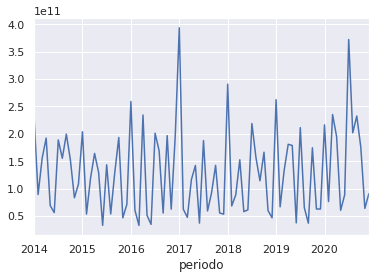

In [24]:
df_result3['25000 - Ministério da Economia'].plot();

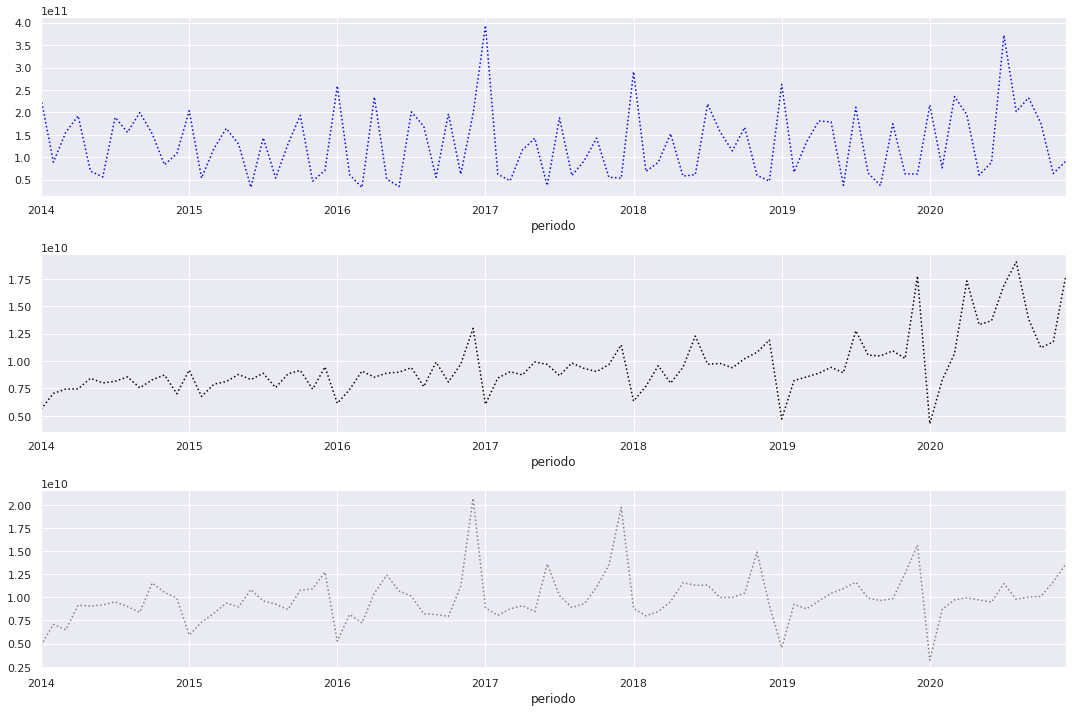

In [25]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,10))
df_result3['25000 - Ministério da Economia'].plot(ax=ax1, ls=':', c='blue')
df_result3['36000 - Ministério da Saúde'].plot(ax=ax2, ls=':', c='black')
df_result3['26000 - Ministério da Educação'].plot(ax=ax3, ls=':', c='grey')

plt.tight_layout()

Foi possível observar uma ligeira tendência de aumento/crescimento nas despesas desses Ministérios. Além disso, há sazonalidade nos gastos. Essas informações ficarão mais claras adiante. Faz-se necessário observar um descolamento das despesas no ano de 2020, em decorrência da situação pandemica do Coronavírus

In [26]:
bkp_gastos = df_result3.copy()

In [27]:
bkp_gastos = bkp_gastos/1000000               # transforma em milhões de R$
bkp_gastos.index.freq = 'MS'                  # month start frequency - frequência mensal

#fonte https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [28]:
bkp_gastos.head()

orgao       20000 - Presidência da República  ...  81000 - Ministério da Mulher, Família e Direitos Humanos
periodo                                       ...                                                          
2014-01-01                         65.190711  ...                                           0.173058       
2014-02-01                         84.797157  ...                                           0.274031       
2014-03-01                         88.075813  ...                                           0.943348       
2014-04-01                        113.064284  ...                                           0.830893       
2014-05-01                        114.764818  ...                                           0.500151       

[5 rows x 28 columns]

In [29]:
bkp_gastos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2014-01-01 to 2020-12-01
Freq: MS
Data columns (total 28 columns):
 #   Column                                                                                  Non-Null Count  Dtype  
---  ------                                                                                  --------------  -----  
 0   20000 - Presidência da República                                                        84 non-null     float64
 1   20113 - Ministério do Planejamento, Desenvolvimento e Gestão                            45 non-null     float64
 2   22000 - Ministério da Agricultura, Pecuária e Abastecimento                             84 non-null     float64
 3   24000 - Ministério da Ciência, Tecnologia, Inovações e Comunicações                     84 non-null     float64
 4   25000 - Ministério da Economia                                                          84 non-null     float64
 5   26000 - Ministério da Educação              

In [30]:
bkp_gastos.index

DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
      

In [31]:
bkp_gastos.tail()

orgao       20000 - Presidência da República  ...  81000 - Ministério da Mulher, Família e Direitos Humanos
periodo                                       ...                                                          
2020-08-01                        122.175583  ...                                          15.718721       
2020-09-01                        130.013960  ...                                          12.012934       
2020-10-01                        125.132673  ...                                         175.871870       
2020-11-01                        160.358941  ...                                          18.729155       
2020-12-01                        248.431446  ...                                          25.923525       

[5 rows x 28 columns]

In [32]:
bkp_gastos.describe()

orgao  20000 - Presidência da República  ...  81000 - Ministério da Mulher, Família e Direitos Humanos
count                         84.000000  ...                                          84.000000       
mean                         148.142613  ...                                          12.238678       
std                           47.508700  ...                                          24.155016       
min                           22.915742  ...                                           0.173058       
25%                          125.268446  ...                                           1.554184       
50%                          145.987753  ...                                           6.499483       
75%                          164.807262  ...                                          14.518627       
max                          389.158138  ...                                         175.871870       

[8 rows x 28 columns]

In [33]:
bkp_gastos.isna().sum()

orgao
20000 - Presidência da República                                                           0
20113 - Ministério do Planejamento, Desenvolvimento e Gestão                              39
22000 - Ministério da Agricultura, Pecuária e Abastecimento                                0
24000 - Ministério da Ciência, Tecnologia, Inovações e Comunicações                        0
25000 - Ministério da Economia                                                             0
26000 - Ministério da Educação                                                             0
30000 - Ministério da Justiça e Segurança Pública                                          0
32000 - Ministério de Minas e Energia                                                      0
33000 - Ministério da Previdência Social                                                   0
35000 - Ministério das Relações Exteriores                                                 0
36000 - Ministério da Saúde                                     

Nota-se que os Ministérios da Economia, Saúde e Educação não possuem valores NaN em sua base

# **Plot dos dados**

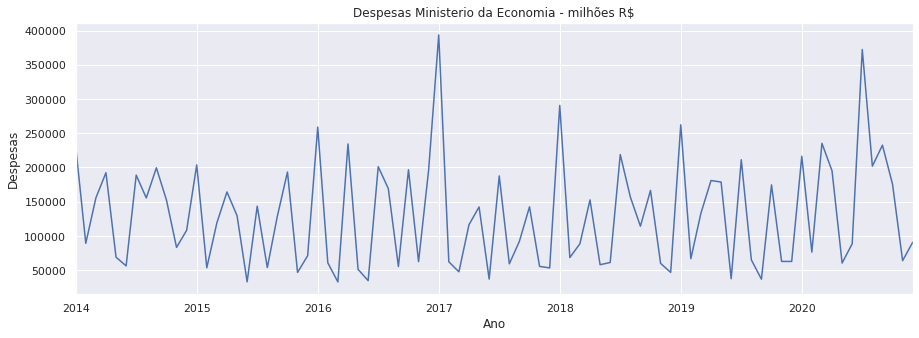

In [34]:
title='Despesas Ministerio da Economia - milhões R$'
ylabel='Despesas'
xlabel='Ano' 
ax = bkp_gastos['25000 - Ministério da Economia'].plot(figsize=(15,5),title=title);
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

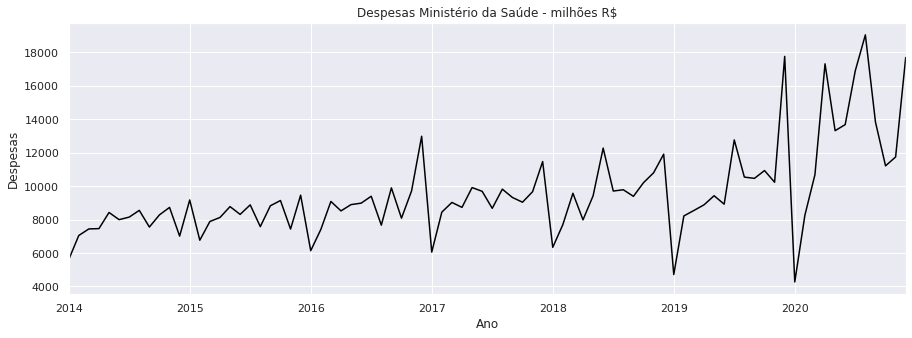

In [35]:
title='Despesas Ministério da Saúde - milhões R$'
ylabel='Despesas'
xlabel='Ano' 
ax = bkp_gastos['36000 - Ministério da Saúde'].plot(figsize=(15,5),title=title, c='black');
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

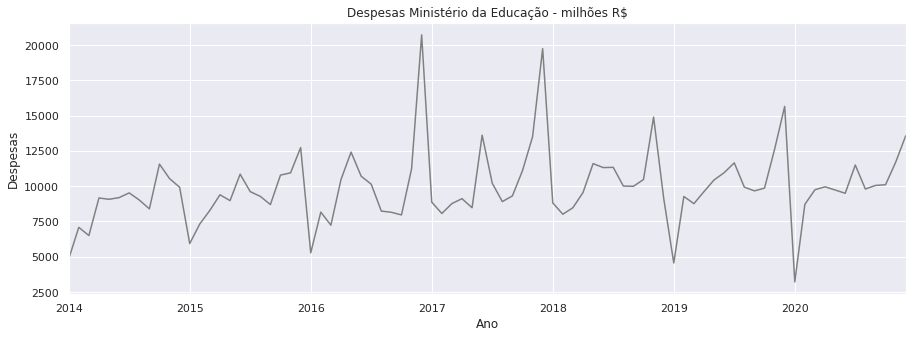

In [36]:
title='Despesas Ministério da Educação - milhões R$'
ylabel='Despesas'
xlabel='Ano' 
ax = bkp_gastos['26000 - Ministério da Educação'].plot(figsize=(15,5),title=title, c='grey');
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);


O gráfico das despesas do Ministério da Economia é bem diferente dos outros listados. Por ser o Ministério que gerencia e dita as regras de gastos da União, talvez esse seja um dos motivos de suas despesas ser tão peculiar e de grande volume. Os Ministérios da Saúde e Educação possuem tendência e sazonalidade semelhantes. 

Interessante notar nesse gráfico o aumento de despesas para o ano de 2020 no Ministério da Saúde, com redução da mesma no Ministério da Educação, em decorrência da pandemia do Coronavirus

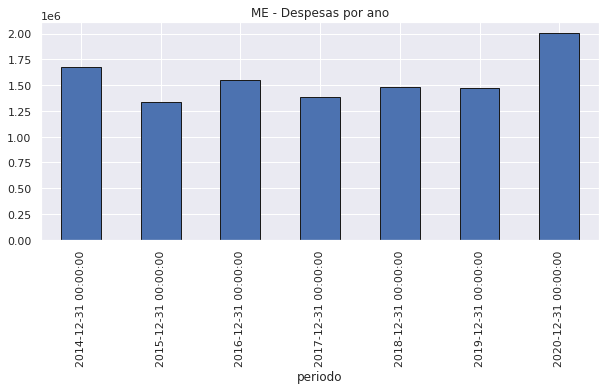

In [37]:
# Variação por ano
bkp_gastos['25000 - Ministério da Economia'].resample('A').sum().plot.bar(figsize = (10,4), grid=True, x = bkp_gastos.index, title='ME - Despesas por ano', edgecolor = 'k');


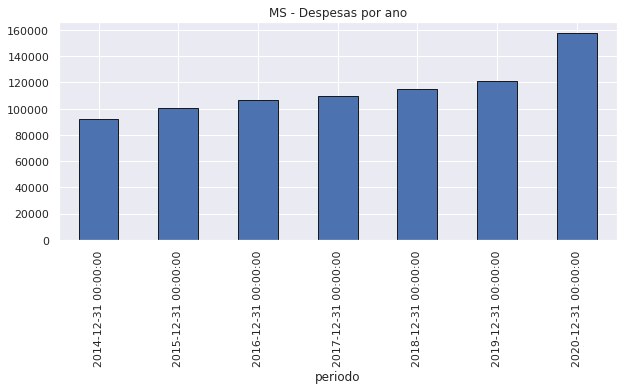

In [38]:
bkp_gastos['36000 - Ministério da Saúde'].resample('A').sum().plot.bar(figsize = (10,4), grid=True, x = bkp_gastos.index, title='MS - Despesas por ano', edgecolor = 'k');


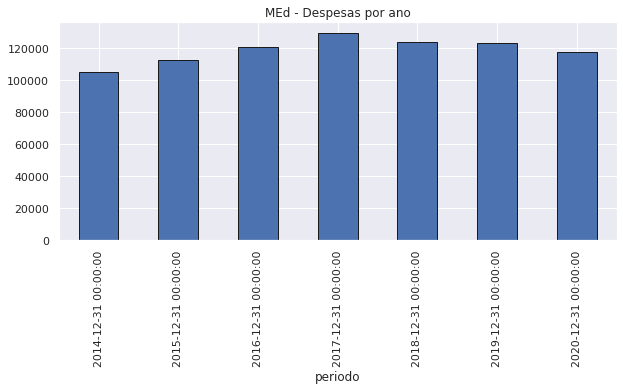

In [39]:
bkp_gastos['26000 - Ministério da Educação'].resample('A').sum().plot.bar(figsize = (10,4), grid=True, x = bkp_gastos.index, title='MEd - Despesas por ano', edgecolor = 'k');

Foi possível observar de forma clara o aumento de despesas para o ano de 2020 nos Ministérios da Economia e Saúde, e a consequente redução de gastos no Ministério da Educação

# **STATSMODEL para obter tendência**

Utilizamos o filtro Hodrick-Prescott

yt = τt + ct

onde:

yt = série temporal


τt = componente de tendência


ct = componente cíclica

lambida (lamb) = 129600 indicando mês

*fonte*: https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html





In [40]:
from statsmodels.tsa.filters.hp_filter import hpfilter
# Separando as variáveis
gastos_cycle, gastos_trend = hpfilter(bkp_gastos['25000 - Ministério da Economia'], lamb=129600)

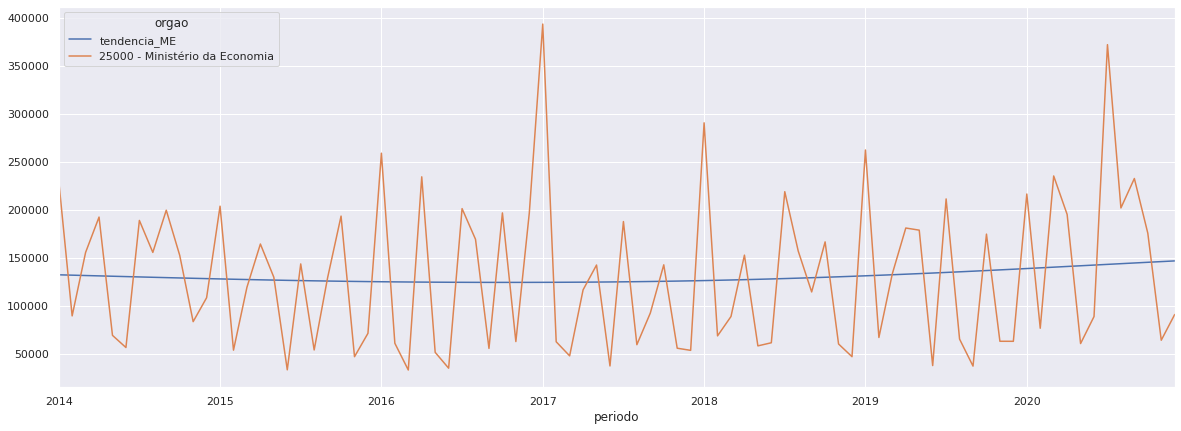

In [41]:
bkp_gastos['tendencia_ME'] = gastos_trend
bkp_gastos[['tendencia_ME','25000 - Ministério da Economia']].plot(figsize = (20,7)).autoscale(axis='x',tight=True);

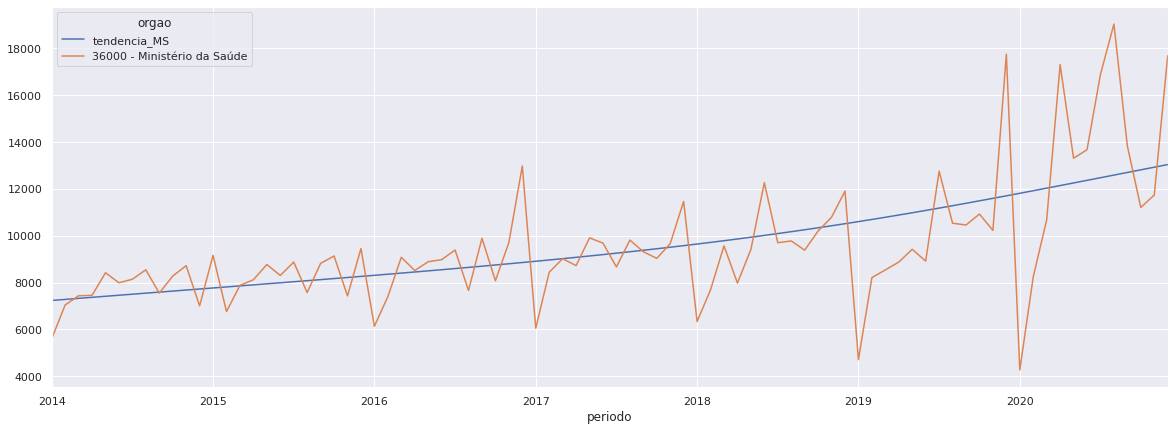

In [42]:
gastos_cycle, gastos_trend = hpfilter(bkp_gastos['36000 - Ministério da Saúde'], lamb=129600)
bkp_gastos['tendencia_MS'] = gastos_trend
bkp_gastos[['tendencia_MS','36000 - Ministério da Saúde']].plot(figsize = (20,7)).autoscale(axis='x',tight=True);

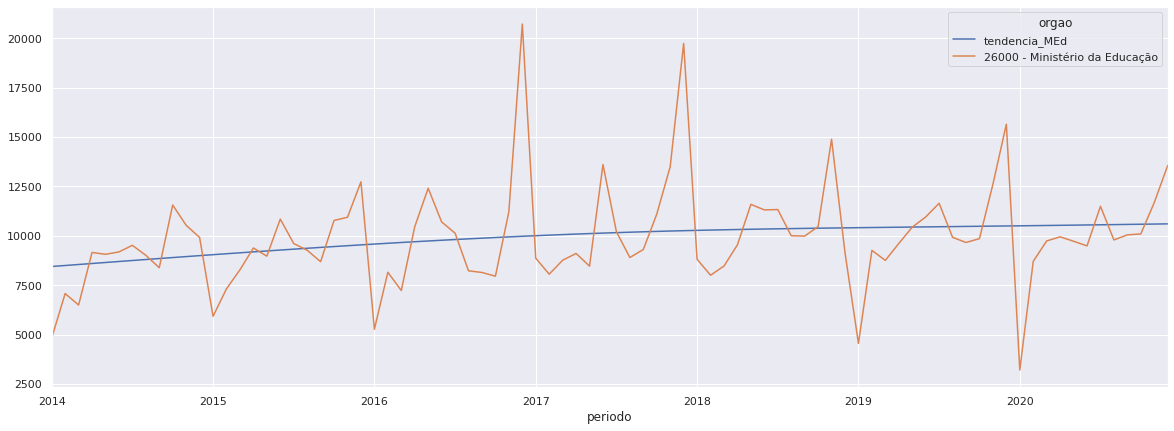

In [43]:
gastos_cycle, gastos_trend = hpfilter(bkp_gastos['26000 - Ministério da Educação'], lamb=129600)
bkp_gastos['tendencia_MEd'] = gastos_trend
bkp_gastos[['tendencia_MEd','26000 - Ministério da Educação']].plot(figsize = (20,7)).autoscale(axis='x',tight=True);

## ERROR / TREND / SEASONALITY

ETS

O decompose é uma tarefa estatistica que descontroi a serie temporal em diversos componentes, cada um representando uma determinada categoria

*fonte*: https://en.wikipedia.org/wiki/Decomposition_of_time_series

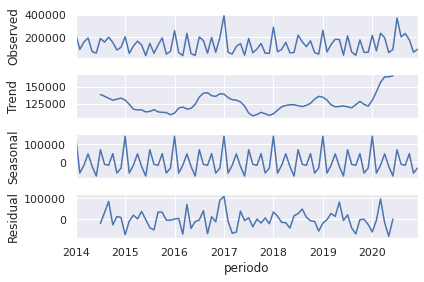

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
visao_geral = seasonal_decompose(bkp_gastos['25000 - Ministério da Economia'], model='add')
visao_geral.plot();

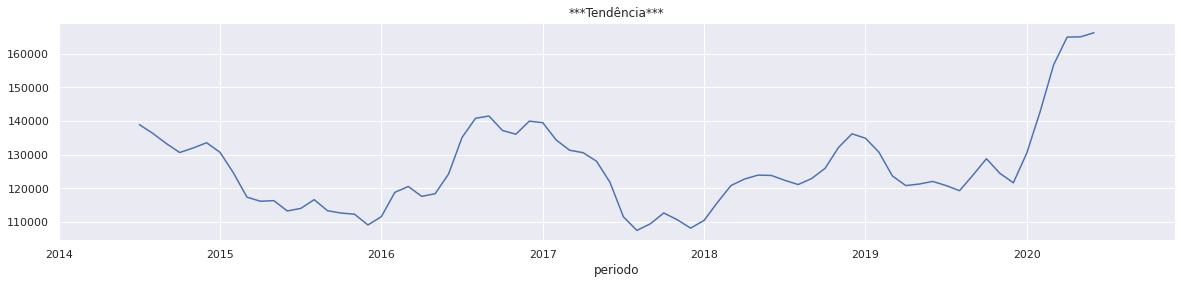

In [45]:
visao_geral.trend.plot(figsize=(20,4), title='***Tendência***');

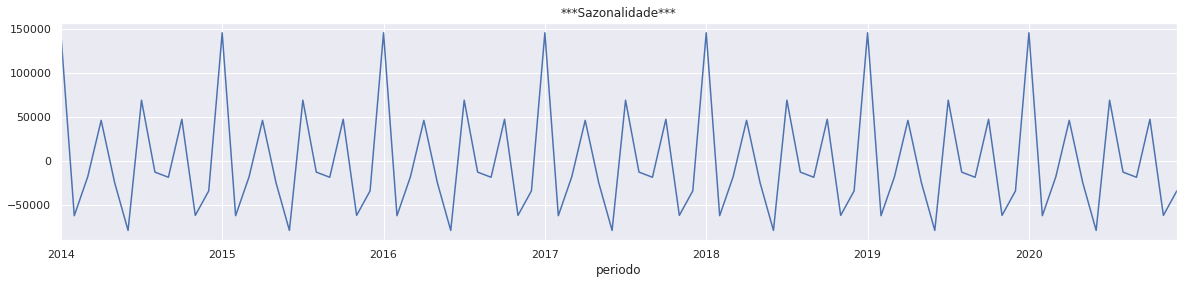

In [46]:
visao_geral.seasonal.plot(figsize=(20,4), title='***Sazonalidade***');

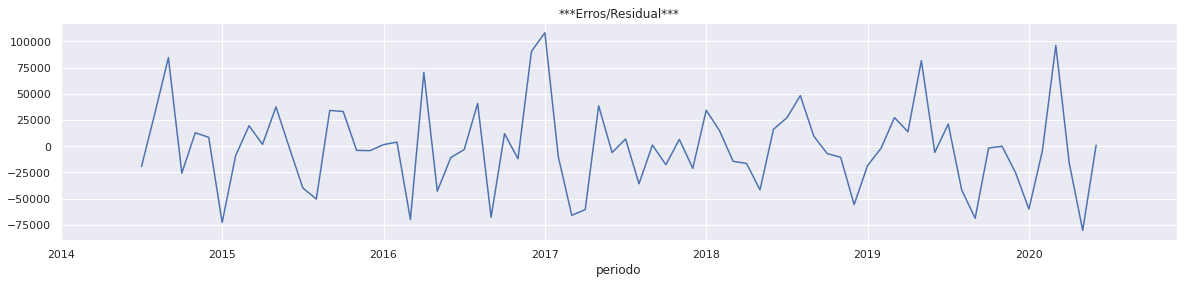

In [47]:
visao_geral.resid.plot(figsize=(20,4), title='***Erros/Residual***');

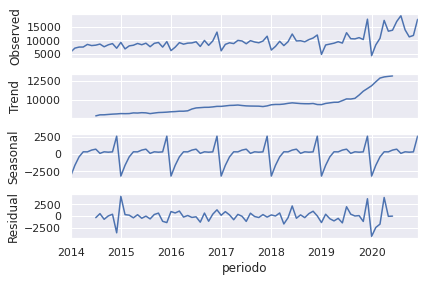

In [48]:
visao_geral = seasonal_decompose(bkp_gastos['36000 - Ministério da Saúde'], model='add')
visao_geral.plot();

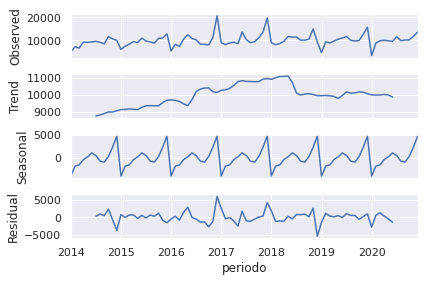

In [49]:
visao_geral = seasonal_decompose(bkp_gastos['26000 - Ministério da Educação'], model='add')
visao_geral.plot();

# Teste Estatísticos de Dickey-Fuller e KPSS

O Teste de Dickey-Fuller busca, entre outras coisas, identificar se os dados trabalhados são classificados como estacionários ou não estacionários.

Usamos o valor P base de 5%, ou seja, caso o valor P esteja abaixo desses 5%, significa que a série é estatisticamente estacionária

In [50]:
#Teste de Dickey Fuller - ME
from statsmodels.tsa.stattools import adfuller
adfinput = adfuller(bkp_gastos['25000 - Ministério da Economia'])
adftest = pd.Series(adfinput[0:4], index=['Teste Estatistico Dickey Fuller','Valor-P',
                                          'Lags Usados','Número de observações usadas'])
adftest = round(adftest,4)
    
for key, value in adfinput[4].items():
    adftest["Valores Críticos (%s)"%key] = value.round(4) 
if adfinput[1] <= 0.05:
        print("É estacionário")
else:
        print("É não-estacionária")

adftest



É não-estacionária


Teste Estatistico Dickey Fuller    -2.6843
Valor-P                             0.0768
Lags Usados                        12.0000
Número de observações usadas       71.0000
Valores Críticos (1%)              -3.5260
Valores Críticos (5%)              -2.9032
Valores Críticos (10%)             -2.5890
dtype: float64

O teste KPSS já pressupõe que a série é estacionária e só não será se o valor P for inferior a 5%, ou o teste estatístico for menor que algum valor crítico escolhido

In [51]:
from statsmodels.tsa.stattools import kpss
kpss_input = kpss(bkp_gastos['25000 - Ministério da Economia'])
kpss_test = pd.Series(kpss_input[0:3], index=['Teste Statistico KPSS','Valor-P','Lags Usados'])
kpss_test = round(kpss_test,4)
    
for key, value in kpss_input[3].items():
    kpss_test["Valores Críticos (%s)"%key] = value 
kpss_test

Teste Statistico KPSS       0.1495
Valor-P                     0.1000
Lags Usados                12.0000
Valores Críticos (10%)      0.3470
Valores Críticos (5%)       0.4630
Valores Críticos (2.5%)     0.5740
Valores Críticos (1%)       0.7390
dtype: float64

In [52]:
#Teste de Dickey Fuller - MS

adfinput = adfuller(bkp_gastos['36000 - Ministério da Saúde'])
adftest = pd.Series(adfinput[0:4], index=['Teste Estatistico Dickey Fuller','Valor-P',
                                          'Lags Usados','Número de observações usadas'])
adftest = round(adftest,4)
    
for key, value in adfinput[4].items():
    adftest["Valores Críticos (%s)"%key] = value.round(4) 
if adfinput[1] <= 0.05:
        print("É estacionário")
else:
        print("É não-estacionária")

adftest

É não-estacionária


Teste Estatistico Dickey Fuller     2.3060
Valor-P                             0.9990
Lags Usados                        11.0000
Número de observações usadas       72.0000
Valores Críticos (1%)              -3.5246
Valores Críticos (5%)              -2.9026
Valores Críticos (10%)             -2.5887
dtype: float64

In [53]:
kpss_input = kpss(bkp_gastos['36000 - Ministério da Saúde'])
kpss_test = pd.Series(kpss_input[0:3], index=['Teste Statistico KPSS','Valor-P','Lags Usados'])
kpss_test = round(kpss_test,4)
    
for key, value in kpss_input[3].items():
    kpss_test["Valores Críticos (%s)"%key] = value 
kpss_test

Teste Statistico KPSS       0.6311
Valor-P                     0.0198
Lags Usados                12.0000
Valores Críticos (10%)      0.3470
Valores Críticos (5%)       0.4630
Valores Críticos (2.5%)     0.5740
Valores Críticos (1%)       0.7390
dtype: float64

In [54]:
#Teste de Dickey Fuller - MEd

adfinput = adfuller(bkp_gastos['26000 - Ministério da Educação'])
adftest = pd.Series(adfinput[0:4], index=['Teste Estatistico Dickey Fuller','Valor-P',
                                          'Lags Usados','Número de observações usadas'])
adftest = round(adftest,4)
    
for key, value in adfinput[4].items():
    adftest["Valores Críticos (%s)"%key] = value.round(4) 
if adfinput[1] <= 0.05:
        print("É estacionário")
else:
        print("É não-estacionária")

adftest

É não-estacionária


Teste Estatistico Dickey Fuller    -1.7018
Valor-P                             0.4302
Lags Usados                        11.0000
Número de observações usadas       72.0000
Valores Críticos (1%)              -3.5246
Valores Críticos (5%)              -2.9026
Valores Críticos (10%)             -2.5887
dtype: float64

In [55]:
kpss_input = kpss(bkp_gastos['26000 - Ministério da Educação'])
kpss_test = pd.Series(kpss_input[0:3], index=['Teste Statistico KPSS','Valor-P','Lags Usados'])
kpss_test = round(kpss_test,4)
    
for key, value in kpss_input[3].items():
    kpss_test["Valores Críticos (%s)"%key] = value 
kpss_test

Teste Statistico KPSS       0.4899
Valor-P                     0.0439
Lags Usados                12.0000
Valores Críticos (10%)      0.3470
Valores Críticos (5%)       0.4630
Valores Críticos (2.5%)     0.5740
Valores Críticos (1%)       0.7390
dtype: float64

# Transformando dados Não Estacionários em Estacionários

**Primeiro método: INFLAÇÃO**



Para tentar tornar a série estacionária, colocaremos a série toda com base nos valores atuais pelo IPCA, acumulando do final do periodo (dez/20) até o início do estudo.

*fonte:* https://agenciadenoticias.ibge.gov.br/

In [56]:
infl = pd.read_excel('IPCA_ajustada.xlsx',sheet_name='IPCA', parse_dates=True)
infl['Data'] = pd.to_datetime(infl['Data'])
infl.set_index('Data', inplace=True)
infl.head()


ANO  Mês    IPCA  Unnamed: 4  Unnamed: 5  Acumulado      Acum
Data                                                                      
2002-11-01  2002   11  0.0302    1.030200         218   2.867418  2.867418
2002-12-01  2002   12  0.0210    1.051834         217   2.829223  2.829223
2003-01-01  2003    1  0.0225    1.075500         216   2.804265  2.804265
2003-02-01  2003    2  0.0157    1.092386         215   2.780354  2.780354
2003-03-01  2003    3  0.0123    1.105822         214   2.762673  2.762673

In [57]:
#Criando colunas de Ano e Mês para mesclar os dados com a base do IPCA
bkp_gastos['ANO'] = bkp_gastos.index.year
bkp_gastos['Mês'] = bkp_gastos.index.month


#Mesclando
index = bkp_gastos.index
bkp_gastos = bkp_gastos.merge(infl.loc[:,['ANO','Mês','Acumulado']], how='left', on=['ANO','Mês'])
bkp_gastos['Despesa ME Ajustada'] = bkp_gastos['25000 - Ministério da Economia'] * bkp_gastos['Acumulado']
bkp_gastos['Despesa MS Ajustada'] = bkp_gastos['36000 - Ministério da Saúde'] * bkp_gastos['Acumulado']
bkp_gastos['Despesa MEd Ajustada'] = bkp_gastos['26000 - Ministério da Educação'] * bkp_gastos['Acumulado']
bkp_gastos.set_index(index, inplace=True)
bkp_gastos.head()

20000 - Presidência da República  ...  Despesa MEd Ajustada
periodo                                       ...                      
2014-01-01                         65.190711  ...           7454.484120
2014-02-01                         84.797157  ...          10895.237306
2014-03-01                         88.075813  ...           9974.438140
2014-04-01                        113.064284  ...          14041.923548
2014-05-01                        114.764818  ...          13867.128096

[5 rows x 37 columns]

In [58]:
#Teste de Dickey Fuller
def adfuller_test(serie, figsize=(18,4), plot=True, title=""):
    if plot:
        serie.plot(figsize=figsize, title=title)
        plt.show()
    #Teste de Dickey Fuller sobre a primeira diferenciação
    adf = adfuller(serie)
    output = pd.Series(adf[0:4], index=['Teste Estatistico Dickey Fuller','Valor-P',
                                          'Lags Usados','Número de observações usadas'])
    output = round(output,4)
    
    for key, value in adf[4].items():
        output["Valores Críticos (%s)"%key] = value.round(4) 
    return output

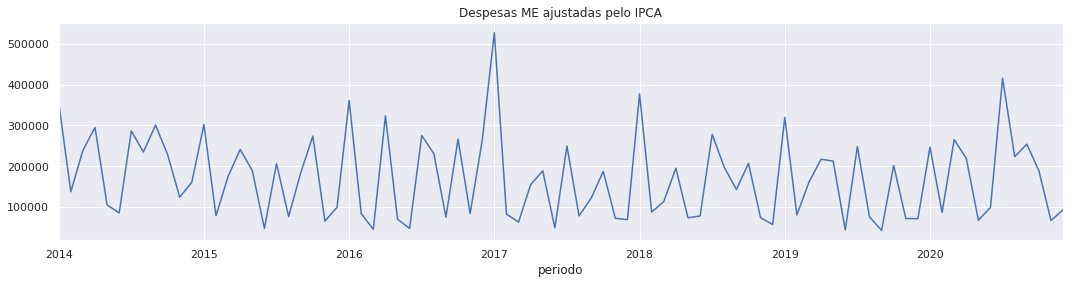

Teste Estatistico Dickey Fuller    -3.1597
Valor-P                             0.0224
Lags Usados                        12.0000
Número de observações usadas       71.0000
Valores Críticos (1%)              -3.5260
Valores Críticos (5%)              -2.9032
Valores Críticos (10%)             -2.5890
dtype: float64

In [59]:
#adfuller_test(bkp_gastos['Despesa Ajustada'],title='Despesas da União ajustadas pelo IPCA')
adfuller_test(bkp_gastos['Despesa ME Ajustada'],title='Despesas ME ajustadas pelo IPCA')


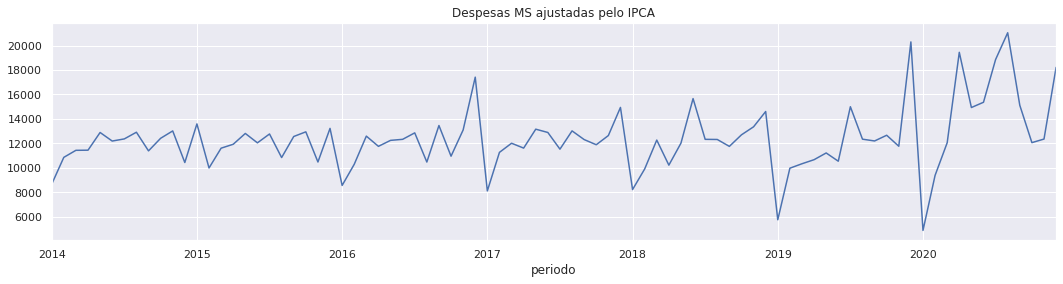

Teste Estatistico Dickey Fuller     0.4192
Valor-P                             0.9822
Lags Usados                        11.0000
Número de observações usadas       72.0000
Valores Críticos (1%)              -3.5246
Valores Críticos (5%)              -2.9026
Valores Críticos (10%)             -2.5887
dtype: float64

In [60]:
adfuller_test(bkp_gastos['Despesa MS Ajustada'],title='Despesas MS ajustadas pelo IPCA')


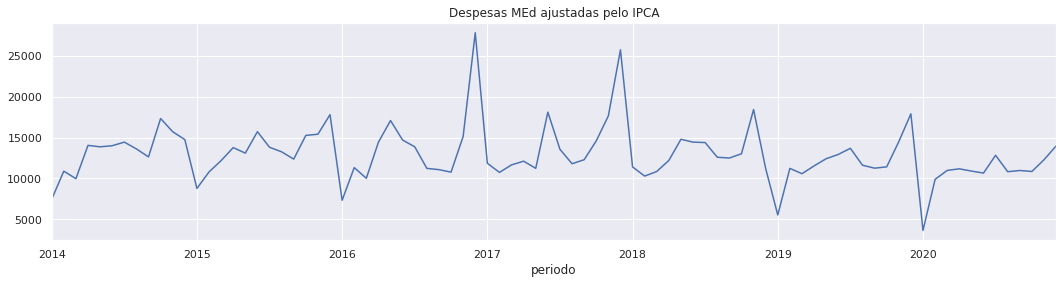

Teste Estatistico Dickey Fuller    -0.0392
Valor-P                             0.9552
Lags Usados                        11.0000
Número de observações usadas       72.0000
Valores Críticos (1%)              -3.5246
Valores Críticos (5%)              -2.9026
Valores Críticos (10%)             -2.5887
dtype: float64

In [61]:
adfuller_test(bkp_gastos['Despesa MEd Ajustada'],title='Despesas MEd ajustadas pelo IPCA')

Como pode ser visto, a tendência de alta desapareceu apenas para o gráfico do Ministério da Economia (ME), ficando as oscilações sazonais. O teste de Dickey Fuller também confirma que a série para o ME agora é estacionária, contudo, necessitamos de um segundo método que transforme os demais Ministérios em dados Estacionários

Apenas para curiosidade, o gráfico a seguir representa as Despesas do ME original x Ajustada pela Inflação

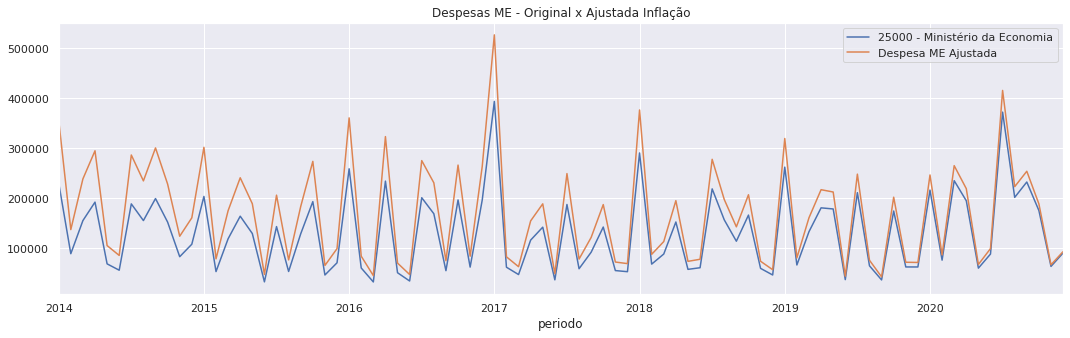

In [62]:
bkp_gastos.loc[:,['25000 - Ministério da Economia','Despesa ME Ajustada']].plot(figsize=(18,5), title='Despesas ME - Original x Ajustada Inflação')
plt.show()

**ACF e PACF dos dados ajustados pela Inflação**

Para ter previsibilidade uma série com uma única variável deve ser auto correlacionada, ou seja, o período atual deve ter explicação com base em um período anterior (lag)


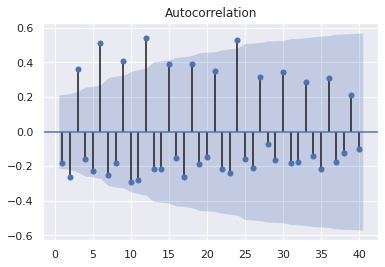

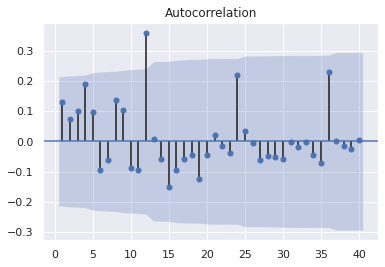

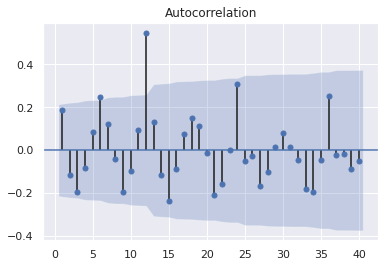

In [63]:
plot_acf(bkp_gastos['Despesa ME Ajustada'], lags=40, zero=False);
plot_acf(bkp_gastos['Despesa MS Ajustada'], lags=40, zero=False);
plot_acf(bkp_gastos['Despesa MEd Ajustada'], lags=40, zero=False);

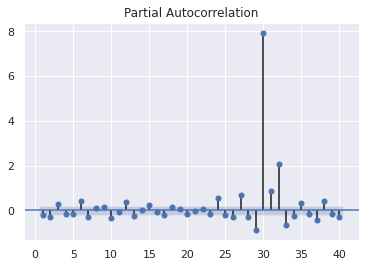

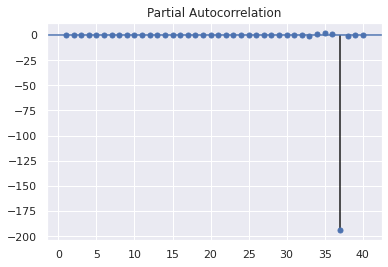

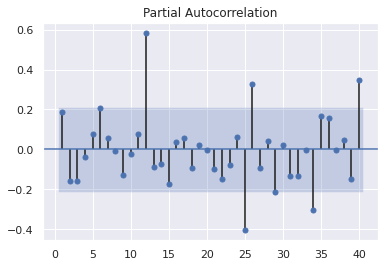

In [64]:
plot_pacf(bkp_gastos['Despesa ME Ajustada'], lags=40, zero=False);
plot_pacf(bkp_gastos['Despesa MS Ajustada'], lags=40, zero=False);
plot_pacf(bkp_gastos['Despesa MEd Ajustada'], lags=40, zero=False);

**Segundo método: DIFERENCIAÇÃO**

A diferenciação é usada para remover os sinais de tendências e reduzir a variância. É simplesmente a diferença do valor do período T com o valor do período anterior T-1

In [65]:
bkp_gastos['ME_dif'] = bkp_gastos['25000 - Ministério da Economia'].diff().dropna()
bkp_gastos['MS_dif'] = bkp_gastos['36000 - Ministério da Saúde'].diff().dropna()
bkp_gastos['MEd_dif'] = bkp_gastos['26000 - Ministério da Educação'].diff().dropna()


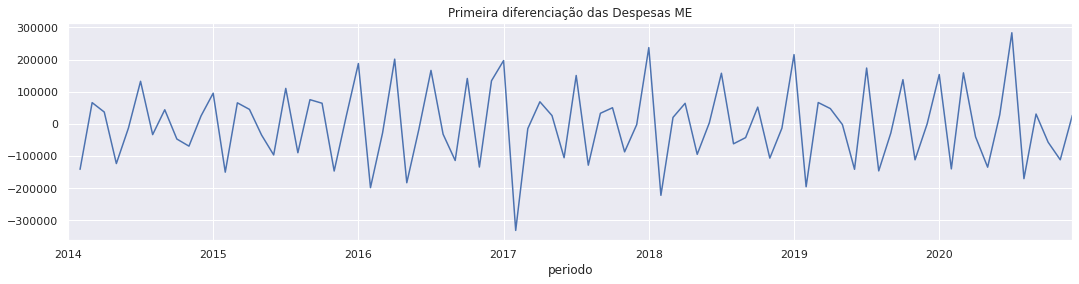

Mostrando as 10 primeiras diferenciações
periodo
2014-02-01   -141447.576353
2014-03-01     66190.121976
2014-04-01     36896.994614
2014-05-01   -123395.406849
2014-06-01    -12683.242913
2014-07-01    132575.004707
2014-08-01    -33355.054806
2014-09-01     44021.086183
2014-10-01    -47058.877850
2014-11-01    -69200.156117
Freq: MS, Name: ME_dif, dtype: float64


In [66]:
bkp_gastos['ME_dif'].plot(figsize=(18,4), title='Primeira diferenciação das Despesas ME')
plt.show()
print('Mostrando as 10 primeiras diferenciações')
print(bkp_gastos['ME_dif'].dropna().head(10))

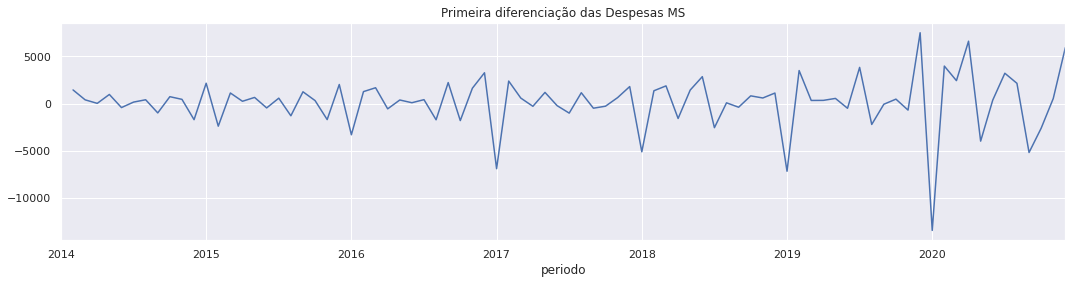

Mostrando as 10 primeiras diferenciações
periodo
2014-02-01    1444.681519
2014-03-01     392.407853
2014-04-01      18.172951
2014-05-01     965.242530
2014-06-01    -429.404894
2014-07-01     152.931970
2014-08-01     401.534979
2014-09-01    -996.323304
2014-10-01     728.544828
2014-11-01     444.813586
Freq: MS, Name: MS_dif, dtype: float64


In [67]:
bkp_gastos['MS_dif'].plot(figsize=(18,4), title='Primeira diferenciação das Despesas MS')
plt.show()
print('Mostrando as 10 primeiras diferenciações')
print(bkp_gastos['MS_dif'].dropna().head(10))

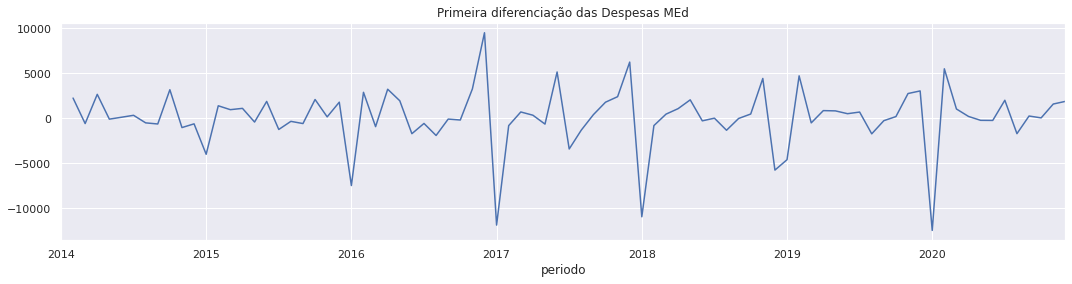

Mostrando as 10 primeiras diferenciações
periodo
2014-02-01    2248.224797
2014-03-01    -582.494512
2014-04-01    2661.810438
2014-05-01     -92.269764
2014-06-01     119.221323
2014-07-01     334.237969
2014-08-01    -504.360727
2014-09-01    -628.625575
2014-10-01    3173.599074
2014-11-01   -1026.747955
Freq: MS, Name: MEd_dif, dtype: float64


In [68]:
bkp_gastos['MEd_dif'].plot(figsize=(18,4), title='Primeira diferenciação das Despesas MEd')
plt.show()
print('Mostrando as 10 primeiras diferenciações')
print(bkp_gastos['MEd_dif'].dropna().head(10))

Normalmente só é necessário uma diferenciação para transformar uma série em estacionária, mas caso seja necessário, pode-se aplicar uma segunda diferenciação. Neste caso a diferenciação será sobre a primeira diferenciação (dificilmente haverá casos com mais do que 2 diferenciações)

Testando Dickey-Fuller nas colunas com diferenciação

In [69]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Passar uma série temporal e um titulo opcional, retorna um relatório ADF
    """
    print(f'Teste de Dickey-Fuller Aumentado: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() para lidar com diferentes dados
    
    labels = ['ADF teste estatístico','p-value','# lags used','# observações']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'valor crítico ({key})']=val
        
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Fortes evidências contra a hipótese nula")
        print("Rejeita a hipótese nula")
        print("É estacionário")
    else:
        print("Fracas evidências contra a hipótese nula")
        print("Falha ao rejeitar a hipótese nula")
        print("É não-estacionária")

In [70]:
adf_test(bkp_gastos['ME_dif'].dropna())

Teste de Dickey-Fuller Aumentado: 
ADF teste estatístico    -4.582948
p-value                   0.000139
# lags used              10.000000
# observações            72.000000
valor crítico (1%)       -3.524624
valor crítico (5%)       -2.902607
valor crítico (10%)      -2.588679
Fortes evidências contra a hipótese nula
Rejeita a hipótese nula
É estacionário


In [71]:
adf_test(bkp_gastos['MS_dif'].dropna())

Teste de Dickey-Fuller Aumentado: 
ADF teste estatístico    -2.405226
p-value                   0.140267
# lags used              12.000000
# observações            70.000000
valor crítico (1%)       -3.527426
valor crítico (5%)       -2.903811
valor crítico (10%)      -2.589320
Fracas evidências contra a hipótese nula
Falha ao rejeitar a hipótese nula
É não-estacionária


In [72]:
adf_test(bkp_gastos['MEd_dif'].dropna())

Teste de Dickey-Fuller Aumentado: 
ADF teste estatístico   -8.013862e+00
p-value                  2.165045e-12
# lags used              1.000000e+01
# observações            7.200000e+01
valor crítico (1%)      -3.524624e+00
valor crítico (5%)      -2.902607e+00
valor crítico (10%)     -2.588679e+00
Fortes evidências contra a hipótese nula
Rejeita a hipótese nula
É estacionário


Foi possível observar que, ao aplicar a primeira diferenciação para cada Ministério, vemos os Min. da Economia (e seu respectivo valor ajustado pela inflação) e da Educação com dados totalmente estacionários, contudo, o Min. da Saúde permanece com dados não estacionários. Para isso, faz-se necessário utilizar a segunda diferenciação

Segunda DIFERENCIAÇÃO para o Ministério da Saude


In [73]:
bkp_gastos['MS_dif'] = bkp_gastos['36000 - Ministério da Saúde'].diff().diff().dropna()

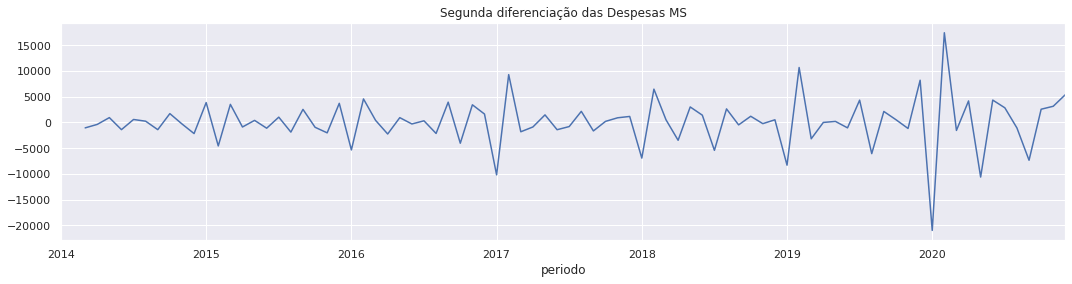

Mostrando as 10 primeiras diferenciações
periodo
2014-03-01   -1052.273666
2014-04-01    -374.234903
2014-05-01     947.069580
2014-06-01   -1394.647424
2014-07-01     582.336864
2014-08-01     248.603009
2014-09-01   -1397.858283
2014-10-01    1724.868132
2014-11-01    -283.731241
2014-12-01   -2159.735998
Freq: MS, Name: MS_dif, dtype: float64


In [74]:
bkp_gastos['MS_dif'].plot(figsize=(18,4), title='Segunda diferenciação das Despesas MS')
plt.show()
print('Mostrando as 10 primeiras diferenciações')
print(bkp_gastos['MS_dif'].dropna().head(10))

In [75]:
adf_test(bkp_gastos['MS_dif'].dropna())

Teste de Dickey-Fuller Aumentado: 
ADF teste estatístico   -8.246901e+00
p-value                  5.522832e-13
# lags used              1.200000e+01
# observações            6.900000e+01
valor crítico (1%)      -3.528890e+00
valor crítico (5%)      -2.904440e+00
valor crítico (10%)     -2.589656e+00
Fortes evidências contra a hipótese nula
Rejeita a hipótese nula
É estacionário


A partir deste momento, temos todas as bases com dados ditos ESTACIONÁRIOS. Desta forma, seguiremos neste estudo com aplicações de modelos de previsão de Série Temporal utilizando ora dados estacionários (AUTO-ARIMA), ora não estacionários (Holt-Winter e Facebook Prophet)

In [76]:
train = bkp_gastos.loc[:'2018-12-01']
test = bkp_gastos.loc['2019-01-01':]


In [77]:
train.tail()

20000 - Presidência da República  ...      MEd_dif
periodo                                       ...             
2018-08-01                        179.633502  ... -1324.346263
2018-09-01                        138.130955  ...   -17.471151
2018-10-01                        180.869165  ...   478.231158
2018-11-01                        194.644036  ...  4425.746555
2018-12-01                        389.158138  ... -5747.529953

[5 rows x 40 columns]

In [78]:
test.head()

20000 - Presidência da República  ...      MEd_dif
periodo                                       ...             
2019-01-01                         22.915742  ... -4593.187947
2019-02-01                        103.069368  ...  4713.263699
2019-03-01                        124.694829  ...  -507.289334
2019-04-01                        123.918153  ...   855.626146
2019-05-01                        137.602790  ...   825.994034

[5 rows x 40 columns]

# AUTO-ARIMA

Utilizamos o pmdarima.auto_arima para indicar o melhor modelo para cada base estudada

In [79]:
!pip install pmdarima
from pmdarima import auto_arima   

     |████████████████████████████████| 1.5MB 14.5MB/s 
     |████████████████████████████████| 9.5MB 52.0MB/s 
     |████████████████████████████████| 2.1MB 39.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


##Indicações Ministério da Economia: com diferenciação e com preço ajustado pela Inflação

In [80]:
auto_arima(bkp_gastos['Despesa ME Ajustada'].dropna(),seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(3, 0, 5)x(2, 0, 0, 12)   Log Likelihood               -1056.220
Date:                            Sat, 10 Apr 2021   AIC                           2136.440
Time:                                    15:30:18   BIC                           2165.610
Sample:                                         0   HQIC                          2148.166
                                             - 84                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.654e+05   1.25e-05   2.12e+10      0.000    2.65e+05    2.65e+05
ar.L1         -1.0124      0.509     -1.989      0.047      -2.010      -0.015
ar.L2         -1.0102      0.501     -2.015      0.044      -1.993      -0.027
ar.L3         -0.0146      0.504     -0.029      0.977      -1.003       0.974
ma.L1          1.1737      0.557      2.109      0.035       0.083       2.265
ma.L2          1.1366      0.694      1.639      0.101      -0.223       2.496
ma.L3          0.0286      0.724      0.040      0.968      -1.391       1.448
ma.L4         -0.1499      0.305     -0.492      0.623      -0.747       0.447
ma.L5         -0.1484      0.198     -0.748      0.455      -0.537       0.240
ar.S.L12       0.1639      0.178      0.922      0.356      -0.184       0.512
ar.S.L24       0.3318      0.175      1.901      0.057      -0.010       0.674
sigma2       5.44e+09   1.55e-10   3.51e+19      0.000    5.44e+09    5.44e+09
===================================================================================
Ljung-Box (Q):                       21.86   Jarque-Bera (JB):                 7.89
Prob(Q):                              0.99   Prob(JB):                         0.02
Heteroskedasticity (H):               0.95   Skew:                             0.71
Prob(H) (two-sided):                  0.89   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.51e+36. Standard errors may be unstable.
"""

##Indicação Ministério da Saúde com diferenciação

In [81]:
auto_arima(bkp_gastos.MS_dif.dropna(),seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   82
Model:             SARIMAX(1, 0, 1)x(1, 0, 0, 12)   Log Likelihood                -747.801
Date:                            Sat, 10 Apr 2021   AIC                           1505.602
Time:                                    15:30:39   BIC                           1517.635
Sample:                                         0   HQIC                          1510.433
                                             - 82                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1219      6.588     -0.019      0.985     -13.034      12.790
ar.L1         -0.4673      0.078     -6.029      0.000      -0.619      -0.315
ma.L1         -0.9787      0.091    -10.802      0.000      -1.156      -0.801
ar.S.L12       0.6792      0.110      6.152      0.000       0.463       0.896
sigma2      4.198e+06   5.83e+05      7.205      0.000    3.06e+06    5.34e+06
===================================================================================
Ljung-Box (Q):                       70.43   Jarque-Bera (JB):                25.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.68   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##Indicação Ministério da Educação com diferenciação

In [82]:
auto_arima(bkp_gastos.MEd_dif.dropna(),seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   83
Model:             SARIMAX(5, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -754.147
Date:                            Sat, 10 Apr 2021   AIC                           1528.295
Time:                                    15:32:07   BIC                           1552.483
Sample:                                         0   HQIC                          1538.012
                                             - 83                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.0270     16.322      0.124      0.901     -29.963      34.017
ar.L1          0.0358      0.256      0.140      0.889      -0.465       0.537
ar.L2         -0.2453      0.334     -0.735      0.463      -0.900       0.409
ar.L3         -0.1214      0.425     -0.286      0.775      -0.954       0.712
ar.L4         -0.1746      0.352     -0.496      0.620      -0.864       0.515
ar.L5         -0.0830      0.260     -0.320      0.749      -0.592       0.426
ma.L1         -0.8649      0.221     -3.916      0.000      -1.298      -0.432
ar.S.L12       0.9022      0.182      4.969      0.000       0.546       1.258
ma.S.L12      -0.6161      0.333     -1.847      0.065      -1.270       0.038
sigma2      6.266e+06   1.53e-05   4.09e+11      0.000    6.27e+06    6.27e+06
===================================================================================
Ljung-Box (Q):                       17.77   Jarque-Bera (JB):               138.74
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                             0.20
Prob(H) (two-sided):                  0.03   Kurtosis:                         9.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+28. Standard errors may be unstable.
"""

##Ajustando os modelos nas bases de treino

**Ministério da Economia com despesas ajustadas pela Inflação**

In [83]:
model_sarima_ME = SARIMAX(train['Despesa ME Ajustada'].dropna(),order=(3,0,5),seasonal_order=(2,0,0,12))
results_sarima_ME = model_sarima_ME.fit()
results_sarima_ME.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                Despesa ME Ajustada   No. Observations:                   60
Model:             SARIMAX(3, 0, 5)x(2, 0, 0, 12)   Log Likelihood                -761.701
Date:                            Sat, 10 Apr 2021   AIC                           1545.403
Time:                                    15:32:10   BIC                           1568.440
Sample:                                01-01-2014   HQIC                          1554.414
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3551      0.700     -0.507      0.612      -1.728       1.018
ar.L2          0.7702      0.208      3.705      0.000       0.363       1.178
ar.L3          0.5793      0.634      0.914      0.361      -0.663       1.821
ma.L1          0.4916      0.655      0.751      0.453      -0.792       1.775
ma.L2         -0.8327      0.356     -2.340      0.019      -1.530      -0.135
ma.L3         -0.6877      0.739     -0.930      0.352      -2.136       0.761
ma.L4          0.1605      0.277      0.580      0.562      -0.382       0.703
ma.L5         -0.0206      0.356     -0.058      0.954      -0.718       0.677
ar.S.L12       0.3833      0.222      1.726      0.084      -0.052       0.819
ar.S.L24       0.3554      0.261      1.359      0.174      -0.157       0.868
sigma2      6.728e+09   4.24e-10   1.59e+19      0.000    6.73e+09    6.73e+09
===================================================================================
Ljung-Box (Q):                       39.62   Jarque-Bera (JB):                11.68
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.80
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.74e+34. Standard errors may be unstable.
"""

In [84]:
# Obtendo a previsão
inicio = len(train)
fim = len(train)+len(test)-1
predictions_sarima_ME = results_sarima_ME.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('SARIMA(3,0,5)(2,0,0,12) Previsões - ME')

In [85]:
# Comparando a previsão com os valores esperados
for i in range(len(predictions_sarima_ME)):
    print(f"predicted={predictions_sarima_ME[i]:<11.10}, expected={test['Despesa ME Ajustada'][i]}")

predicted=350592.4057, expected=319517.2232448776
predicted=116721.6017, expected=80933.61795470581
predicted=87558.00947, expected=161081.20693436387
predicted=159413.773 , expected=217200.637926258
predicted=134586.2745, expected=212603.4247543776
predicted=68792.7504 , expected=44223.490176924286
predicted=234808.3759, expected=248303.91988798845
predicted=128641.3402, expected=76191.63543070751
predicted=132093.3976, expected=42975.54550985554
predicted=176147.1411, expected=202221.5698529857
predicted=84199.11293, expected=72182.13020551435
predicted=78903.85723, expected=71759.66229953362
predicted=297315.729 , expected=246642.26739943962
predicted=107890.8464, expected=86810.25742145017
predicted=103685.7532, expected=265275.78239159624
predicted=161339.8477, expected=219275.49920923475
predicted=108324.7936, expected=67744.57409044722
predicted=84319.33105, expected=99513.53711038354
predicted=219381.5146, expected=415611.8561092594
predicted=149544.9932, expected=223234.092304

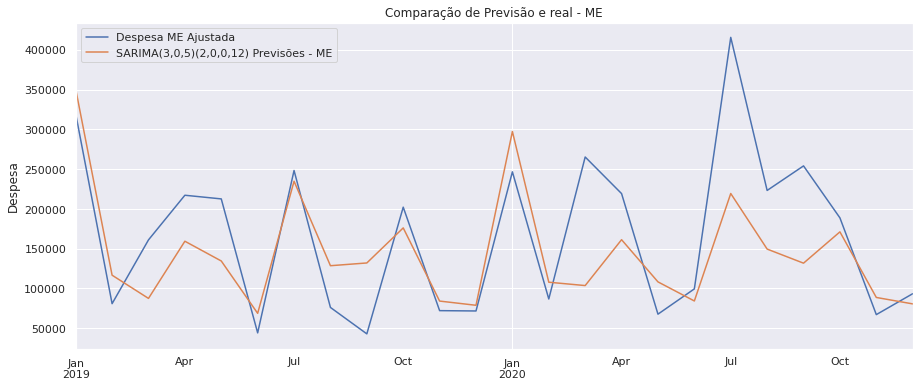

In [86]:
# Plotar previsões em relação aos valores conhecidos
title = 'Comparação de Previsão e real - ME'
ylabel='Despesa'
xlabel=''

ax = test['Despesa ME Ajustada'].plot(legend=True,figsize=(15,6),title=title)
predictions_sarima_ME.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

**Ministério da Saúde com despesas ajustadas por Diferenciação**

In [87]:
model_sarima_MS = SARIMAX(train.MS_dif.dropna(),order=(1,0,1),seasonal_order=(1,0,0,12))
results_sarima_MS = model_sarima_MS.fit(disp = -1)
results_sarima_MS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             MS_dif   No. Observations:                   58
Model:             SARIMAX(1, 0, 1)x(1, 0, 0, 12)   Log Likelihood                -502.953
Date:                            Sat, 10 Apr 2021   AIC                           1013.905
Time:                                    15:32:11   BIC                           1022.147
Sample:                                03-01-2014   HQIC                          1017.115
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5553      0.087     -6.365      0.000      -0.726      -0.384
ma.L1         -1.0000      0.161     -6.202      0.000      -1.316      -0.684
ar.S.L12       0.5210      0.125      4.183      0.000       0.277       0.765
sigma2      1.736e+06   9.29e-08   1.87e+13      0.000    1.74e+06    1.74e+06
===================================================================================
Ljung-Box (Q):                       48.12   Jarque-Bera (JB):                 4.86
Prob(Q):                              0.18   Prob(JB):                         0.09
Heteroskedasticity (H):               1.72   Skew:                             0.09
Prob(H) (two-sided):                  0.25   Kurtosis:                         4.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+30. Standard errors may be unstable.
"""

In [88]:
# Obtendo a previsão
inicio = len(train)-2
fim = len(train)+len(test)-3
predictions_sarima_MS = results_sarima_MS.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('SARIMA(1,0,1)(1,0,0,12) Previsões - ME')

In [89]:
# Comparando a previsão com os valores esperados
for i in range(len(predictions_sarima_MS)):
    print(f"predicted={predictions_sarima_MS[i]:<11.10}, expected={test.MS_dif[i]}")

predicted=-3808.860334, expected=-8311.539567070002
predicted=3489.191336, expected=10701.293028910002
predicted=209.4466094, expected=-3175.845992540001
predicted=-1771.145753, expected=7.794346609998684
predicted=1555.747483, expected=208.17342762000408
predicted=751.1663059, expected=-1048.5109703500038
predicted=-2830.819138, expected=4346.227741530001
predicted=1379.865581, expected=-6064.11620479
predicted=-245.5770927, expected=2146.087364119998
predicted=631.2019079, expected=543.9239639600037
predicted=-118.9910672, expected=-1166.5870854500026
predicted=273.5495296, expected=8222.91605653
predicted=-1984.54199, expected=-21009.616575499997
predicted=1817.923027, expected=17466.136017589997
predicted=109.0673078, expected=-1547.3376730900009
predicted=-922.7180896, expected=4193.352381530003
predicted=810.5108634, expected=-10622.981964630006
predicted=391.3580842, expected=4359.350612180006
predicted=-1474.829807, expected=2856.284621419998
predicted=718.8971597, expected=-10

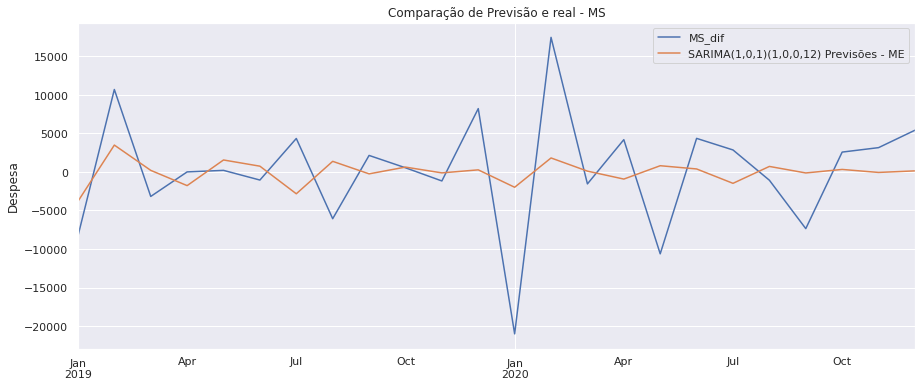

In [90]:
# Plotar previsões em relação aos valores conhecidos
title = 'Comparação de Previsão e real - MS'
ylabel='Despesa'
xlabel=''

ax = test.MS_dif.plot(legend=True,figsize=(15,6),title=title)
predictions_sarima_MS.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

**Ministério da Educação com despesas ajustadas por Diferenciação**

In [91]:
model_sarima_MEd = SARIMAX(train.MEd_dif.dropna(),order=(5,0,1),seasonal_order=(1,0,1,12))
results_sarima_MEd = model_sarima_MEd.fit(disp = -1)
results_sarima_MEd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            MEd_dif   No. Observations:                   59
Model:             SARIMAX(5, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -535.082
Date:                            Sat, 10 Apr 2021   AIC                           1088.163
Time:                                    15:32:12   BIC                           1106.861
Sample:                                02-01-2014   HQIC                          1095.462
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1282      0.224     -0.573      0.567      -0.567       0.310
ar.L2         -0.2303      0.223     -1.033      0.302      -0.667       0.207
ar.L3         -0.2441      0.214     -1.140      0.254      -0.664       0.175
ar.L4         -0.2799      0.253     -1.104      0.269      -0.777       0.217
ar.L5         -0.2600      0.159     -1.637      0.102      -0.571       0.051
ma.L1         -0.8602      0.133     -6.485      0.000      -1.120      -0.600
ar.S.L12       0.3929      0.176      2.236      0.025       0.049       0.737
ma.S.L12       0.2687      0.309      0.869      0.385      -0.337       0.874
sigma2      3.852e+06    7.2e+05      5.349      0.000    2.44e+06    5.26e+06
===================================================================================
Ljung-Box (Q):                       17.56   Jarque-Bera (JB):                56.40
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.03   Skew:                             0.41
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
# Obtendo a previsão
inicio = len(train)-1
fim = len(train)+len(test)-2
predictions_sarima_MEd = results_sarima_MEd.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('SARIMA(5,0,1)(1,0,1,12) Previsões - MEd')

In [93]:
# Comparando a previsão com os valores esperados
for i in range(len(predictions_sarima_MEd)):
    print(f"predicted={predictions_sarima_MEd[i]:<11.10}, expected={test.MEd_dif[i]}")

predicted=599.5180847, expected=-4593.187947239998
predicted=338.229058 , expected=4713.263698669998
predicted=-65.57173805, expected=-507.28933427000084
predicted=641.4536468, expected=855.6261464300042
predicted=1946.568449, expected=825.994034399997
predicted=-2909.602094, expected=513.3927634600022
predicted=671.029489 , expected=695.5561645100006
predicted=-347.8463927, expected=-1722.349718650008
predicted=203.7004113, expected=-262.03040865
predicted=209.1761968, expected=194.67803906000154
predicted=2886.195518, expected=2751.818577619997
predicted=-4761.802447, expected=3040.0617074700076
predicted=1602.341068, expected=-12441.3238728
predicted=193.4249012, expected=5497.379551929999
predicted=-63.75079007, expected=1036.3415515600027
predicted=311.585387 , expected=207.30684875000225
predicted=1019.641613, expected=-223.98533295000198
predicted=-1552.587979, expected=-234.45555048999813
predicted=237.7744068, expected=2003.8762933600028
predicted=-108.0531239, expected=-1702.

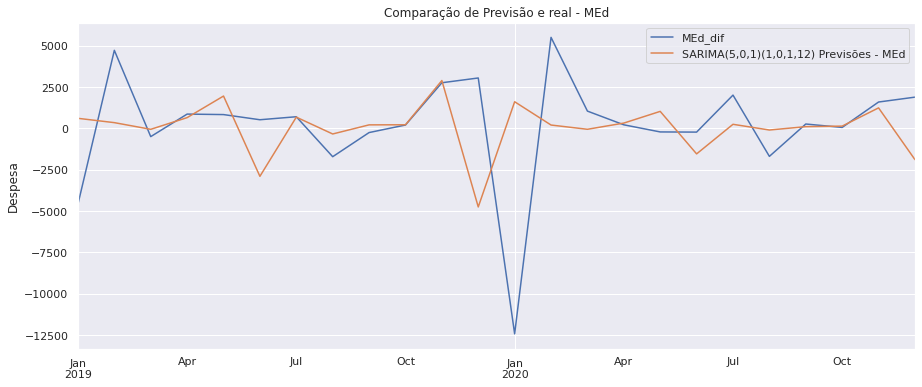

In [94]:
# Plotar previsões em relação aos valores conhecidos
title = 'Comparação de Previsão e real - MEd'
ylabel='Despesa'
xlabel=''

ax = test.MEd_dif.plot(legend=True,figsize=(15,6),title=title)
predictions_sarima_MEd.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

**Ministério da Economia com despesas ajustadas por Diferenciação**

In [95]:
model_sarima_ME_dif = SARIMAX(train.ME_dif.dropna(),order=(0,0,2),seasonal_order=(1,1,0,12))
results_sarima_ME_dif = model_sarima_ME_dif.fit(disp = -1)
results_sarima_ME_dif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             ME_dif   No. Observations:                   59
Model:             SARIMAX(0, 0, 2)x(1, 1, 0, 12)   Log Likelihood                -586.023
Date:                            Sat, 10 Apr 2021   AIC                           1180.046
Time:                                    15:32:13   BIC                           1187.447
Sample:                                02-01-2014   HQIC                          1182.831
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7590      0.210     -3.609      0.000      -1.171      -0.347
ma.L2         -0.0238      0.217     -0.110      0.913      -0.449       0.401
ar.S.L12      -0.4884      0.189     -2.588      0.010      -0.858      -0.119
sigma2      5.538e+09   1.02e-11   5.42e+20      0.000    5.54e+09    5.54e+09
===================================================================================
Ljung-Box (Q):                       32.78   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.78   Prob(JB):                         0.75
Heteroskedasticity (H):               0.49   Skew:                             0.16
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  4e+37. Standard errors may be unstable.
"""

In [96]:
# Obtendo a previsão
inicio = len(train)-1
fim = len(train)+len(test)-2
predictions_sarima_ME_dif = results_sarima_ME_dif.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('SARIMA(0,0,2)(1,1,0,12) Previsões - ME_dif')

In [97]:
# Comparando a previsão com os valores esperados
for i in range(len(predictions_sarima_ME_dif)):
    print(f"predicted={predictions_sarima_ME_dif[i]:<11.10}, expected={test.ME_dif[i]}")

predicted=283016.6753, expected=215598.71245778998
predicted=-273537.872, expected=-195575.78120361
predicted=3162.128194, expected=66525.97385668
predicted=66387.57631, expected=47667.211919640016
predicted=-35787.6044, expected=-2217.8912545499916
predicted=-49760.96422, expected=-141273.58873816003
predicted=154196.6569, expected=173836.80888666003
predicted=-94415.14514, expected=-146205.27986351002
predicted=-5697.63403, expected=-28194.640926729997
predicted=51281.64225, expected=137696.59846006
predicted=-96977.43625, expected=-111785.04163214
predicted=-7862.523143, expected=-42.89782090999506
predicted=260715.8936, expected=153641.79217828
predicted=-248487.5658, expected=-140003.37247533997
predicted=11483.93221, expected=158846.47829446004
predicted=65234.78534, expected=-40128.733206680045
predicted=-64549.47949, expected=-134703.28697537
predicted=-23863.64677, expected=28189.72096143999
predicted=155855.2321, expected=283643.41473492
predicted=-78540.88661, expected=-1703

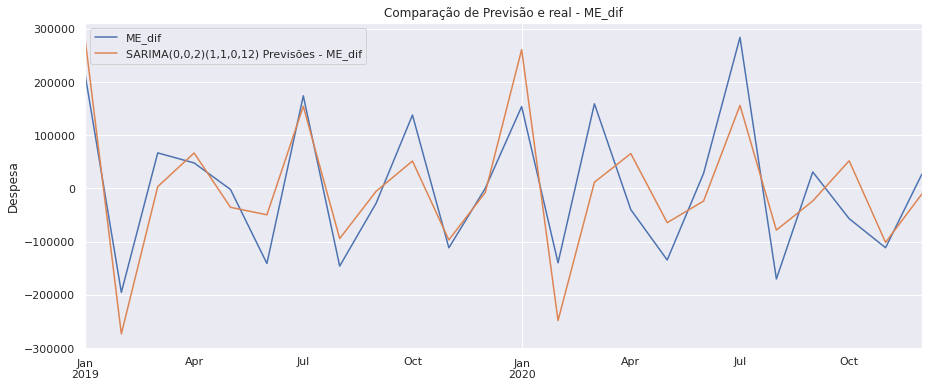

In [98]:
# Plotar previsões em relação aos valores conhecidos
title = 'Comparação de Previsão e real - ME_dif'
ylabel='Despesa'
xlabel=''

ax = test.ME_dif.plot(legend=True,figsize=(15,6),title=title)
predictions_sarima_ME_dif.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

##Previsão de futuro utilizando AUTO-ARIMA 

**Previsão final (12 meses) das despesas do Ministério da Economia com valores ajustados pela Inflação**


In [99]:
modelo_final_sarimax_ME = SARIMAX(bkp_gastos['Despesa ME Ajustada'],order=(3,0,5),seasonal_order=(2,0,0,12))
resultado_final_sarimax_ME = modelo_final_sarimax_ME.fit()
previsao_final_sarimax_ME = resultado_final_sarimax_ME.predict(len(bkp_gastos),len(bkp_gastos)+12,typ='levels').rename('SARIMA(3,0,5)(2,0,0,12) Previsão ME')

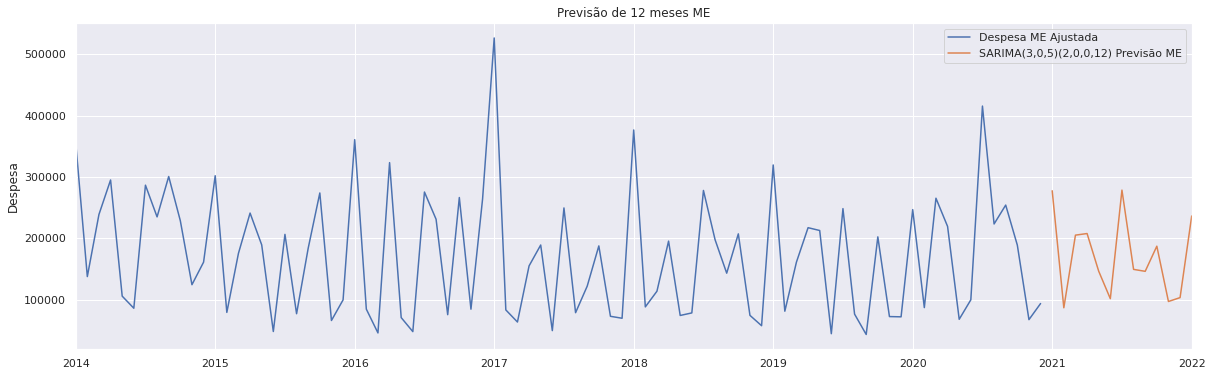

In [100]:
# Plotar previsões de 12 meses para frente
title = 'Previsão de 12 meses ME'
ylabel='Despesa'
xlabel=''

ax = bkp_gastos['Despesa ME Ajustada'].plot(legend=True,figsize=(20,6),title=title)
previsao_final_sarimax_ME.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

**Previsão final (12 meses) das despesas do Ministério da Economia com valores ajustados por Diferenciação**

In [101]:
modelo_final_sarimax_ME_dif = SARIMAX(bkp_gastos.ME_dif,order=(0,0,2),seasonal_order=(1,1,0,12))
resultado_final_sarimax_ME_dif = modelo_final_sarimax_ME_dif.fit()
previsao_final_sarimax_ME_dif = resultado_final_sarimax_ME_dif.predict(len(bkp_gastos),len(bkp_gastos)+12,typ='levels').rename('SARIMA(0,0,2)(1,1,0,12) Previsão ME_dif')

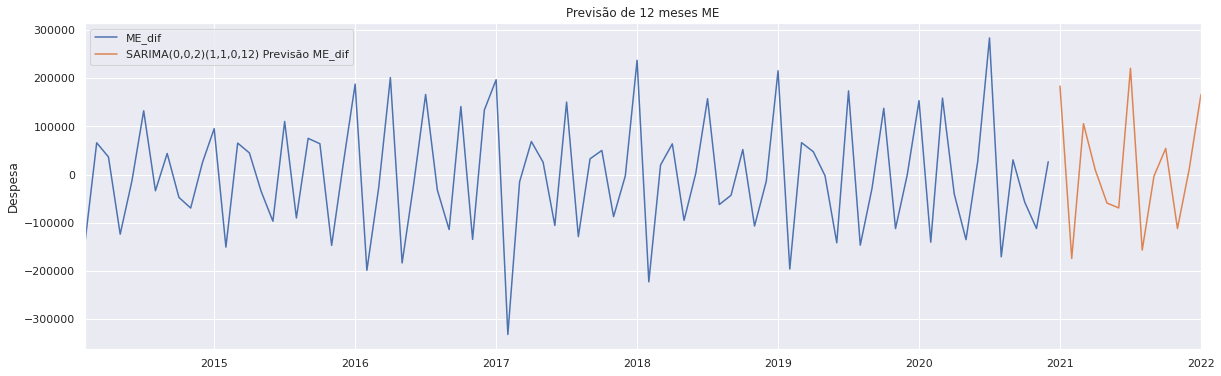

In [102]:
# Plotar previsões de 12 meses para frente
title = 'Previsão de 12 meses ME'
ylabel='Despesa'
xlabel=''

ax = bkp_gastos.ME_dif.plot(legend=True,figsize=(20,6),title=title)
previsao_final_sarimax_ME_dif.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

**Previsão final (12 meses) das despesas do Ministério da Saúde com valores ajustados por Diferenciação**

In [103]:
modelo_final_sarimax_MS = SARIMAX(bkp_gastos.MS_dif,order=(1,0,1),seasonal_order=(1,0,0,12))
resultado_final_sarimax_MS = modelo_final_sarimax_MS.fit()
previsao_final_sarimax_MS = resultado_final_sarimax_MS.predict(len(bkp_gastos),len(bkp_gastos)+12,typ='levels').rename('SARIMA(1,0,1)(1,0,0,12) Previsão MS')

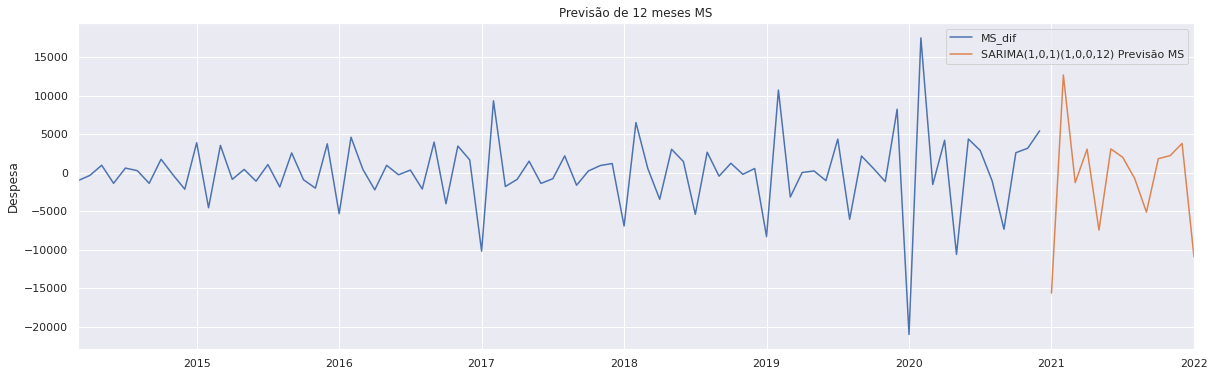

In [104]:
# Plotar previsões de 12 meses para frente
title = 'Previsão de 12 meses MS'
ylabel='Despesa'
xlabel=''

ax = bkp_gastos.MS_dif.plot(legend=True,figsize=(20,6),title=title)
previsao_final_sarimax_MS.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

**Previsão final (12 meses) das despesas do Ministério da Educação com valores ajustados por Diferenciação**

In [105]:
modelo_final_sarimax_MEd = SARIMAX(bkp_gastos.MEd_dif,order=(5,0,1),seasonal_order=(1,0,1,12))
resultado_final_sarimax_MEd = modelo_final_sarimax_MEd.fit()
previsao_final_sarimax_MEd = resultado_final_sarimax_MEd.predict(len(bkp_gastos),len(bkp_gastos)+12,typ='levels').rename('SARIMA(5,0,1)(1,0,1,12) Previsão MEd')

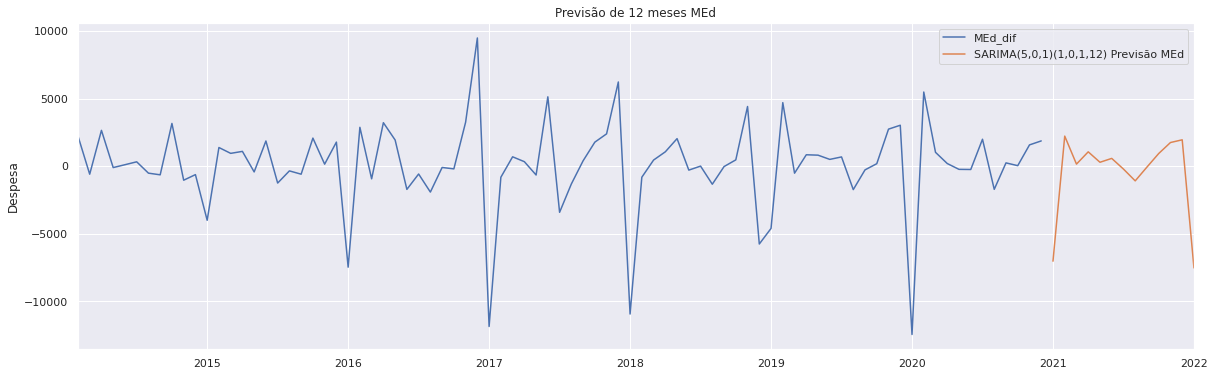

In [106]:
# Plotar previsões de 12 meses para frente
title = 'Previsão de 12 meses MEd'
ylabel='Despesa'
xlabel=''

ax = bkp_gastos.MEd_dif.plot(legend=True,figsize=(20,6),title=title)
previsao_final_sarimax_MEd.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#HOLT WINTERS

O método elaborado por Holt (1957) e Winters (1960) tem como pressuposto fundamental lidar com sazonalidades. Ele possui 3 equações basicas: uma para ajuste de nível, outra para ajustar o crescimento e outra para sazonalidade

*fonte:*  https://otexts.com/fpp2/holt-winters.html

In [107]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

##Treinando a base de despesas do Ministério da Economia com valores ajustados pela Inflação

In [108]:
fitted_model_ME = ExponentialSmoothing(train['Despesa ME Ajustada'],trend='add',seasonal='add',seasonal_periods=12).fit()

In [109]:
test_predictions_ME = fitted_model_ME.forecast(24).rename('Previsão - Holt-Winters - Despesa ME Ajustada')
test_predictions_ME

2019-01-01    348837.620144
2019-02-01     61363.375890
2019-03-01     99535.604487
2019-04-01    216729.253641
2019-05-01    102889.377840
2019-06-01     33927.750142
2019-07-01    224727.265628
2019-08-01    127100.520423
2019-09-01    134444.948949
2019-10-01    212022.147025
2019-11-01     58522.403311
2019-12-01    112813.343535
2020-01-01    337841.738222
2020-02-01     50367.493968
2020-03-01     88539.722565
2020-04-01    205733.371719
2020-05-01     91893.495919
2020-06-01     22931.868220
2020-07-01    213731.383706
2020-08-01    116104.638501
2020-09-01    123449.067028
2020-10-01    201026.265104
2020-11-01     47526.521389
2020-12-01    101817.461613
Freq: MS, Name: Previsão - Holt-Winters - Despesa ME Ajustada, dtype: float64

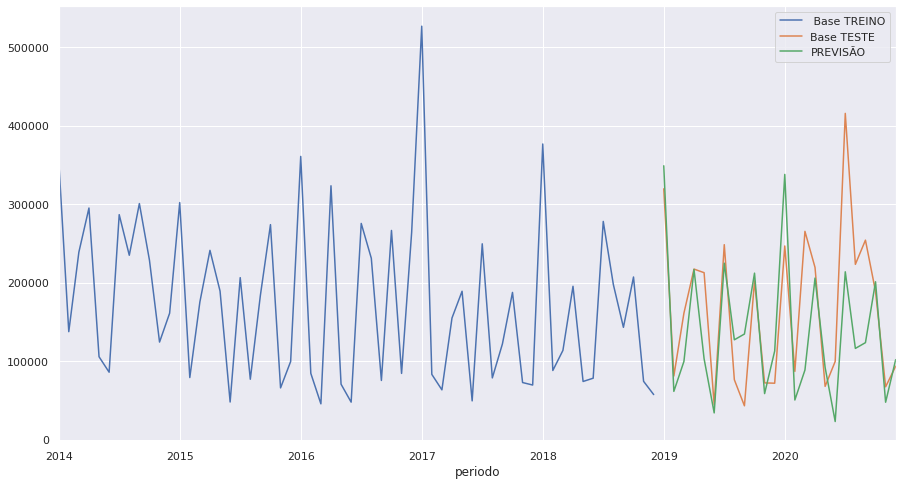

In [110]:
train['Despesa ME Ajustada'].plot(legend=True,label=' Base TREINO')
test['Despesa ME Ajustada'].plot(legend=True,label='Base TESTE',figsize=(15,8))
test_predictions_ME.plot(legend=True,label='PREVISÃO');

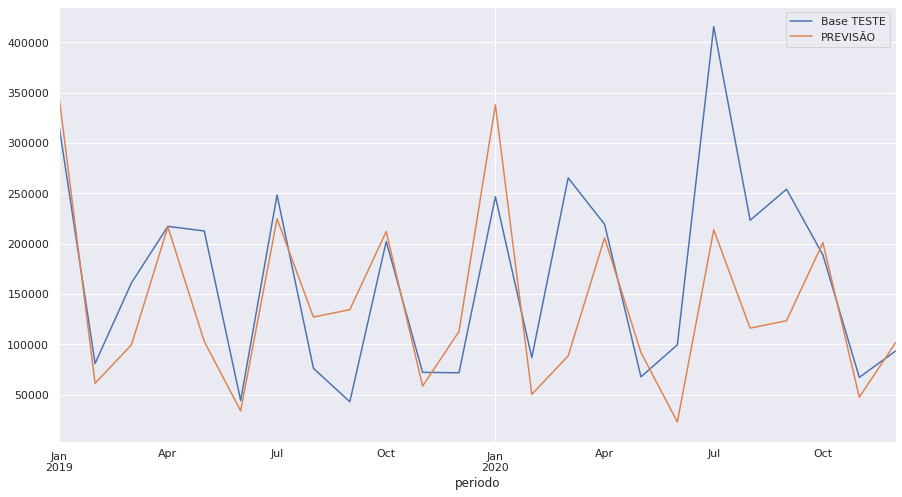

In [111]:
test['Despesa ME Ajustada'].plot(legend=True,label='Base TESTE',figsize=(15,8))
test_predictions_ME.plot(legend=True,label='PREVISÃO',xlim=['2019-01-01','2020-12-01']);

In [112]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [113]:
mae = mean_absolute_error(test['Despesa ME Ajustada'],test_predictions_ME)
mse = mean_squared_error(test['Despesa ME Ajustada'],test_predictions_ME)
rmse = np.sqrt(mean_squared_error(test['Despesa ME Ajustada'],test_predictions_ME))
print(f'erro MAE: {mae}')
print(f'erro MSE: {mse}')
print(f'erro RMSE: {rmse}')


erro MAE: 56664.14481839077
erro MSE: 6169553611.222234
erro RMSE: 78546.50604083057


##Treinando a base de despesas do Ministério da Economia com os valores originais

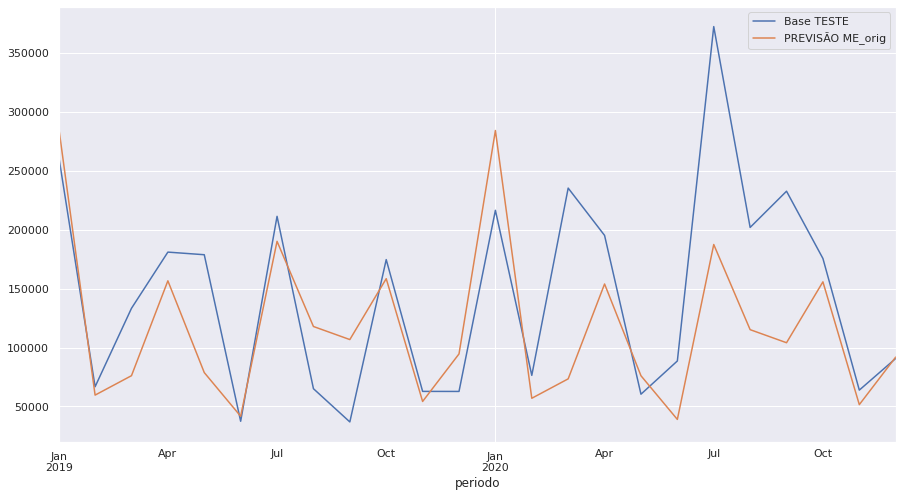

In [114]:
fitted_model_ME_orig = ExponentialSmoothing(train['25000 - Ministério da Economia'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions_ME_orig = fitted_model_ME_orig.forecast(24).rename('Previsão - Holt-Winters - ME origem')
test['25000 - Ministério da Economia'].plot(legend=True,label='Base TESTE',figsize=(15,8))
test_predictions_ME_orig.plot(legend=True,label='PREVISÃO ME_orig',xlim=['2019-01-01','2020-12-01']);

In [115]:
mae = mean_absolute_error(test['25000 - Ministério da Economia'],test_predictions_ME_orig)
mse = mean_squared_error(test['25000 - Ministério da Economia'],test_predictions_ME_orig)
rmse = np.sqrt(mean_squared_error(test['25000 - Ministério da Economia'],test_predictions_ME_orig))
print(f'erro MAE: {mae}')
print(f'erro MSE: {mse}')
print(f'erro RMSE: {rmse}')

erro MAE: 50270.186455678224
erro MSE: 4928456597.607062
erro RMSE: 70202.96715671683


##Treinando a base de despesas do Ministério da Saúde com os valores originais

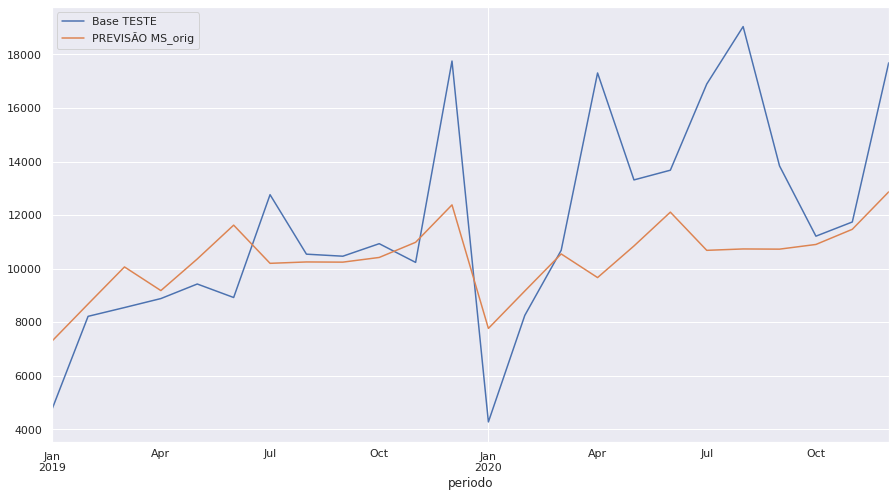

In [116]:
fitted_model_MS_orig = ExponentialSmoothing(train['36000 - Ministério da Saúde'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions_MS_orig = fitted_model_MS_orig.forecast(24).rename('Previsão - Holt-Winters - MS origem')
test['36000 - Ministério da Saúde'].plot(legend=True,label='Base TESTE',figsize=(15,8))
test_predictions_MS_orig.plot(legend=True,label='PREVISÃO MS_orig',xlim=['2019-01-01','2020-12-01']);

In [117]:
mae = mean_absolute_error(test['36000 - Ministério da Saúde'],test_predictions_MS_orig)
mse = mean_squared_error(test['36000 - Ministério da Saúde'],test_predictions_MS_orig)
rmse = np.sqrt(mean_squared_error(test['36000 - Ministério da Saúde'],test_predictions_MS_orig))
print(f'erro MAE: {mae}')
print(f'erro MSE: {mse}')
print(f'erro RMSE: {rmse}')

erro MAE: 2394.268761213631
erro MSE: 11442697.93742841
erro RMSE: 3382.705712507136


##Treinando a base de despesas do Ministério da Educação com os valores originais

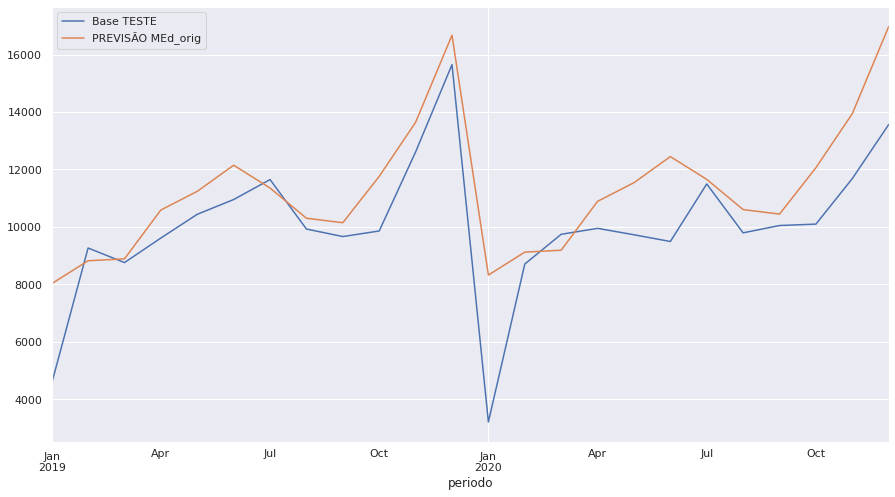

In [118]:
fitted_model_MEd_orig = ExponentialSmoothing(train['26000 - Ministério da Educação'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions_MEd_orig = fitted_model_MEd_orig.forecast(24).rename('Previsão - Holt-Winters - MEd origem')
test['26000 - Ministério da Educação'].plot(legend=True,label='Base TESTE',figsize=(15,8))
test_predictions_MEd_orig.plot(legend=True,label='PREVISÃO MEd_orig',xlim=['2019-01-01','2020-12-01']);

In [119]:
mae = mean_absolute_error(test['26000 - Ministério da Educação'],test_predictions_MEd_orig)
mse = mean_squared_error(test['26000 - Ministério da Educação'],test_predictions_MEd_orig)
rmse = np.sqrt(mean_squared_error(test['26000 - Ministério da Educação'],test_predictions_MEd_orig))
print(f'erro MAE: {mae}')
print(f'erro MSE: {mse}')
print(f'erro RMSE: {rmse}')

erro MAE: 1371.775626642618
erro MSE: 3436136.861761887
erro RMSE: 1853.6819742776502


##Previsão de futuro utilizando Holt-Winters


**Previsão final (12 meses) das despesas do Ministério da Economia com valores ajustados pela Inflação**

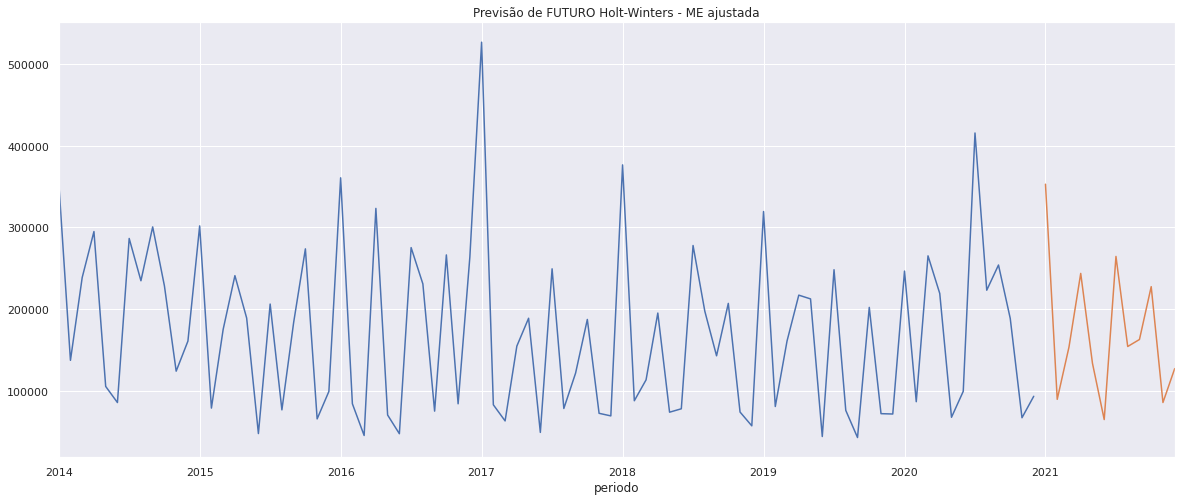

In [120]:
modelo_HW_futuro_ME = ExponentialSmoothing(bkp_gastos['Despesa ME Ajustada'],trend='add',seasonal='add',seasonal_periods=12).fit()
predição_HW_ME = modelo_HW_futuro_ME.forecast(12)
bkp_gastos['Despesa ME Ajustada'].plot(figsize=(20,8), title = 'Previsão de FUTURO Holt-Winters - ME ajustada')
predição_HW_ME.plot();

**Previsão final (12 meses) das despesas do Ministério da Economia com valores originais**

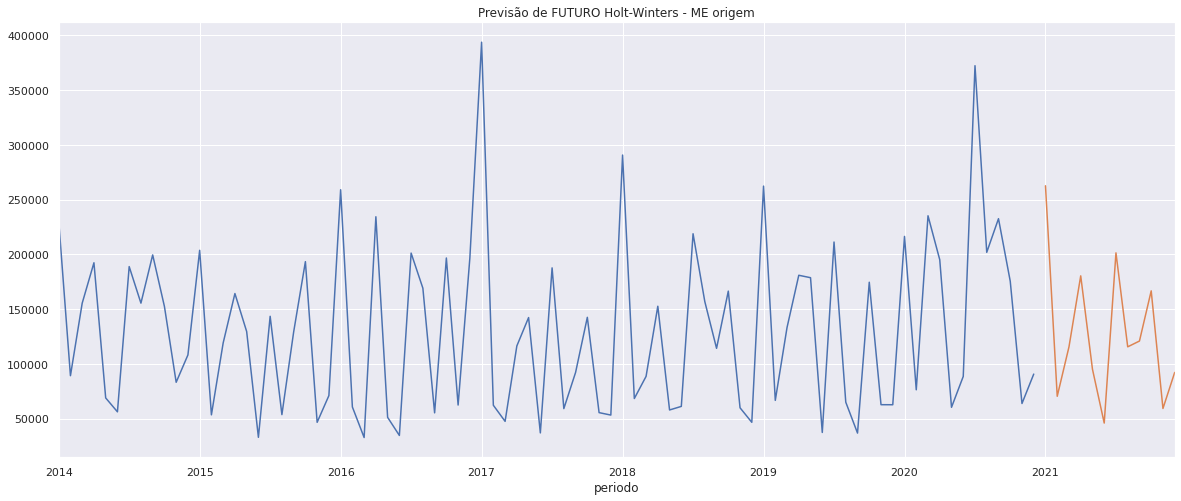

In [121]:
modelo_HW_futuro_ME_orig = ExponentialSmoothing(bkp_gastos['25000 - Ministério da Economia'],trend='add',seasonal='add',seasonal_periods=12).fit()
predição_HW_ME_orig = modelo_HW_futuro_ME_orig.forecast(12)
bkp_gastos['25000 - Ministério da Economia'].plot(figsize=(20,8), title = 'Previsão de FUTURO Holt-Winters - ME origem')
predição_HW_ME_orig.plot();

**Previsão final (12 meses) das despesas do Ministério da Saúde com valores originais**

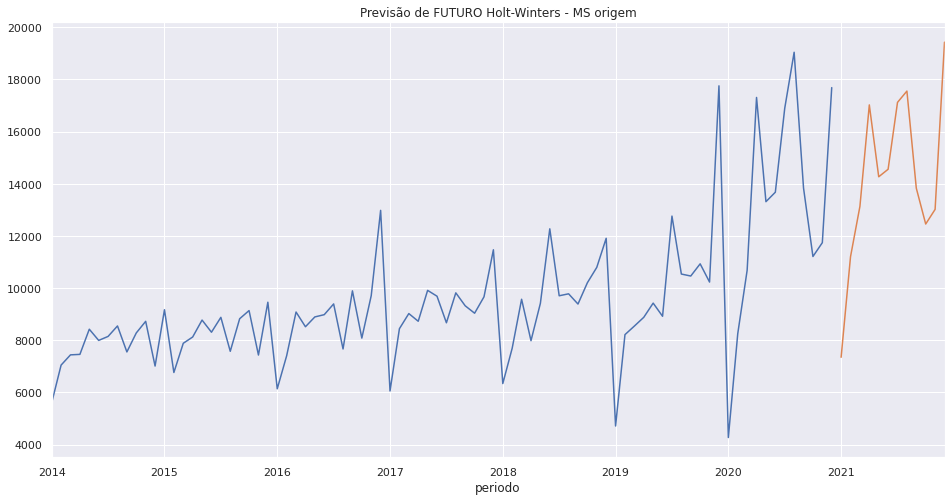

In [122]:
modelo_HW_futuro_MS_orig = ExponentialSmoothing(bkp_gastos['36000 - Ministério da Saúde'],trend='add',seasonal='add',seasonal_periods=12).fit()
predição_HW_MS_orig = modelo_HW_futuro_MS_orig.forecast(12)
bkp_gastos['36000 - Ministério da Saúde'].plot(figsize=(16,8), title = 'Previsão de FUTURO Holt-Winters - MS origem')
predição_HW_MS_orig.plot();

**Previsão final (12 meses) das despesas do Ministério da Educação com valores originais**

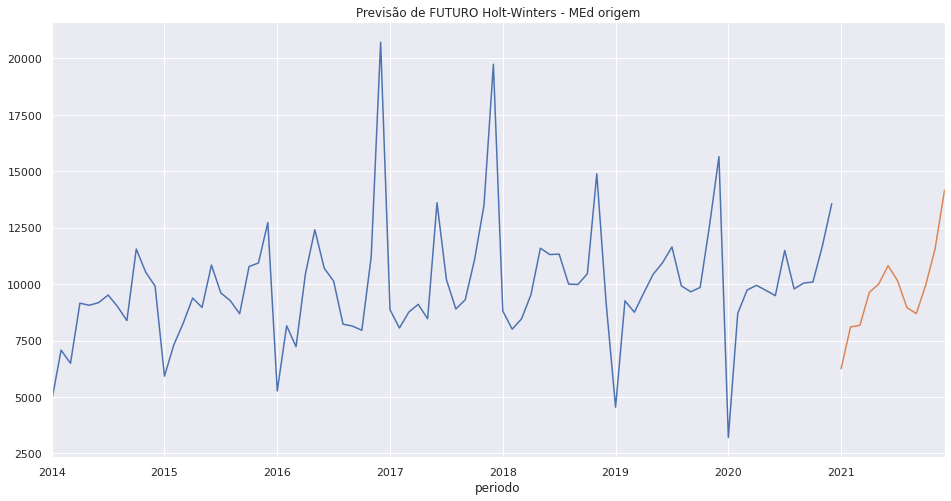

In [123]:
modelo_HW_futuro_MEd_orig = ExponentialSmoothing(bkp_gastos['26000 - Ministério da Educação'],trend='add',seasonal='add',seasonal_periods=12).fit()
predição_HW_MEd_orig = modelo_HW_futuro_MEd_orig.forecast(12)
bkp_gastos['26000 - Ministério da Educação'].plot(figsize=(16,8), title = 'Previsão de FUTURO Holt-Winters - MEd origem')
predição_HW_MEd_orig.plot();

#Facebook Prophet

A equipe do Facebook desenvolveu um modelo que captura e interpreta a sazonalidade e a tendência em dados de séries temporais, podendo ser, por exemplo, anualmente, semanalmente e diariamente, além de séries personalizadas. A biblioteca foi desenvolvida para a equipe de analistas do Facebook, mas também é open source.

*fonte:* https://facebook.github.io/prophet/

In [124]:
from fbprophet import Prophet
from statsmodels.tools.eval_measures import rmse

**Preparando os dados**

In [125]:
bkp_gastos_prophet = pd.DataFrame(bkp_gastos)

In [126]:
bkp_gastos_prophet['PERIODO'] = bkp_gastos_prophet.index


##Treinando a base de despesas do Ministério da Economia com os valores originais

In [127]:
df_prophet_ME = pd.DataFrame(bkp_gastos_prophet, columns=['PERIODO', '25000 - Ministério da Economia'])
df_prophet_ME.head()


PERIODO  25000 - Ministério da Economia
periodo                                              
2014-01-01 2014-01-01                   230707.875070
2014-02-01 2014-02-01                    89260.298717
2014-03-01 2014-03-01                   155450.420693
2014-04-01 2014-04-01                   192347.415307
2014-05-01 2014-05-01                    68952.008458

In [128]:
df_prophet_ME.columns = ['ds','y']

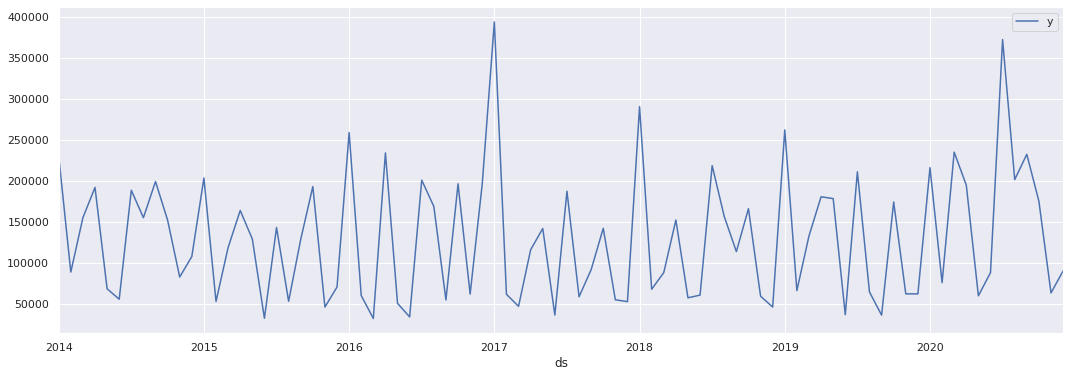

In [129]:
df_prophet_ME.plot(x='ds',y='y',figsize=(18,6))

In [130]:
len(df_prophet_ME)

84

In [131]:
len(df_prophet_ME)-24

60

In [132]:
train_prophet_ME = df_prophet_ME.iloc[:60]
test_prophet_ME = df_prophet_ME.iloc[60:]

In [133]:
m = Prophet()
m.fit(train_prophet_ME)
future = m.make_future_dataframe(periods=24,freq='MS')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [134]:
forecast.tail()

ds          trend  ...  multiplicative_terms_upper           yhat
79 2020-08-01  107648.343626  ...                         0.0  140661.992875
80 2020-09-01  107396.684105  ...                         0.0   49391.869049
81 2020-10-01  107153.142634  ...                         0.0  143819.579294
82 2020-11-01  106901.483113  ...                         0.0   32221.677320
83 2020-12-01  106657.941641  ...                         0.0  118382.773687

[5 rows x 16 columns]

In [135]:
test_prophet_ME.tail()

ds              y
periodo                             
2020-08-01 2020-08-01  201871.600921
2020-09-01 2020-09-01  232582.689376
2020-10-01 2020-10-01  175522.286653
2020-11-01 2020-11-01   63872.607726
2020-12-01 2020-12-01   90715.459922

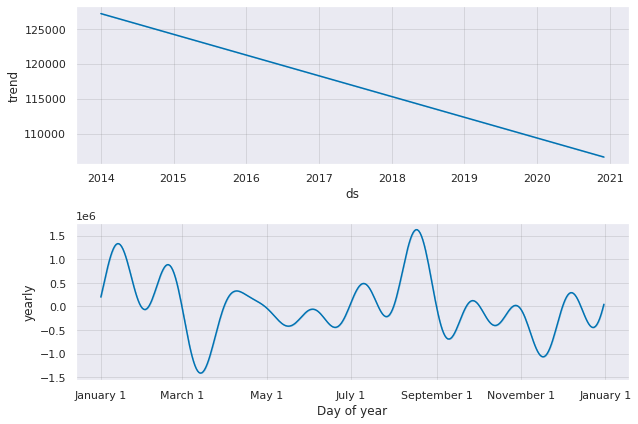

In [136]:
fig = m.plot_components(forecast)

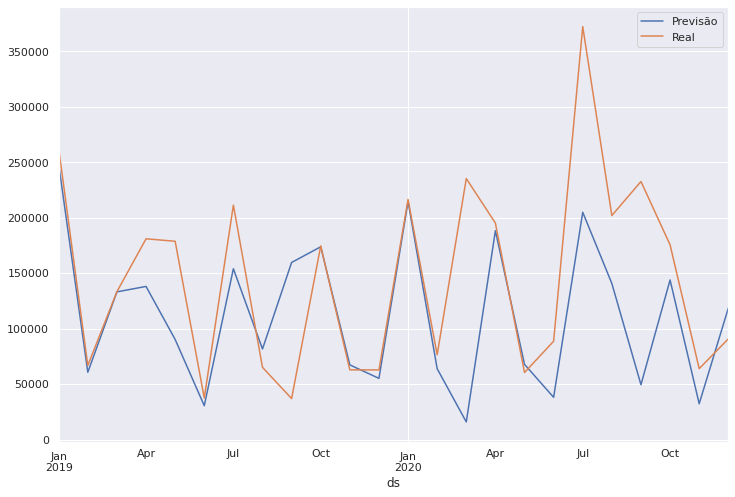

In [137]:
ax = forecast.plot(x='ds',y='yhat',label='Previsão',legend=True,figsize=(12,8))

test_prophet_ME.plot(x='ds',y='y',label='Real',legend=True,ax=ax,xlim=('2019-01-01','2020-12-01'))

In [138]:
predictions = forecast.iloc[-24:]['yhat']
predictions

60    247992.375457
61     60621.791540
62    133091.595102
63    137987.360399
64     90173.164008
65     30450.911205
66    153931.603811
67     81593.702778
68    159580.799114
69    173698.329791
70     67258.323081
71     55107.264821
72    214591.581627
73     63812.806312
74     15836.477700
75    188230.210459
76     67736.520321
77     38039.192533
78    204843.372247
79    140661.992875
80     49391.869049
81    143819.579294
82     32221.677320
83    118382.773687
Name: yhat, dtype: float64

In [139]:
test_prophet_ME['y']

periodo
2019-01-01    262311.577100
2019-02-01     66735.795897
2019-03-01    133261.769754
2019-04-01    180928.981673
2019-05-01    178711.090419
2019-06-01     37437.501680
2019-07-01    211274.310567
2019-08-01     65069.030704
2019-09-01     36874.389777
2019-10-01    174570.988237
2019-11-01     62785.946605
2019-12-01     62743.048784
2020-01-01    216384.840962
2020-02-01     76381.468487
2020-03-01    235227.946781
2020-04-01    195099.213575
2020-05-01     60395.926599
2020-06-01     88585.647561
2020-07-01    372229.062296
2020-08-01    201871.600921
2020-09-01    232582.689376
2020-10-01    175522.286653
2020-11-01     63872.607726
2020-12-01     90715.459922
Freq: MS, Name: y, dtype: float64

In [140]:
rmse(predictions,test_prophet_ME['y'])

78453.00942599571

In [141]:
test_prophet_ME.mean()

y    145065.549252
dtype: float64

###Previsão de futuro da base de despesas do Ministério da Economia com os valores originais

In [142]:
m = Prophet()
m.fit(train_prophet_ME)
future = m.make_future_dataframe(periods=36,freq='MS')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


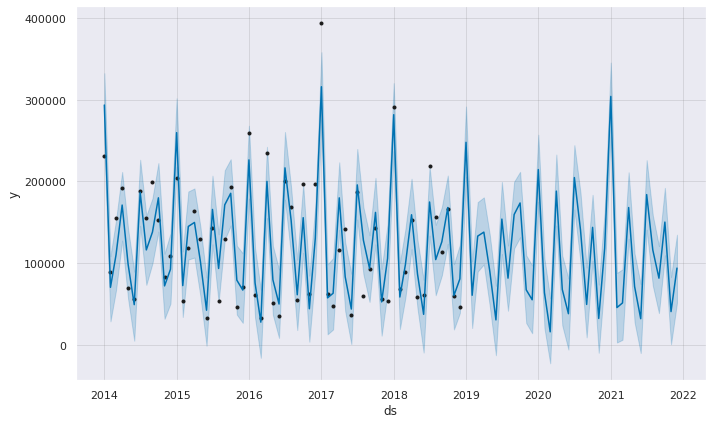

In [143]:
m.plot(forecast);

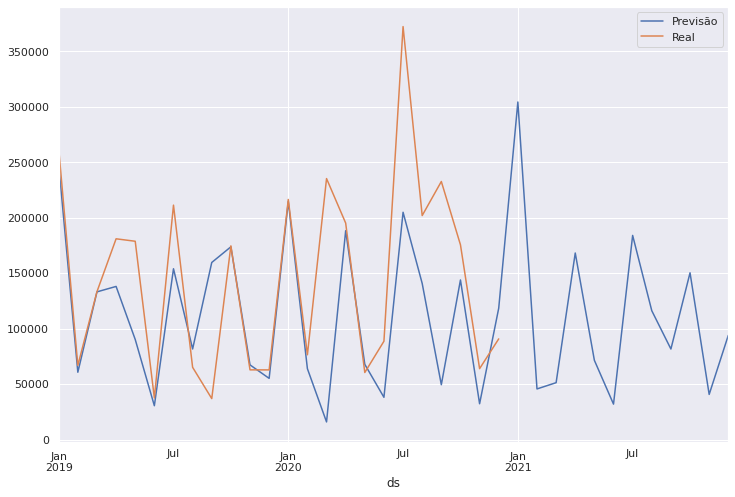

In [144]:
ax = forecast.plot(x='ds',y='yhat',label='Previsão',legend=True,figsize=(12,8))

test_prophet_ME.plot(x='ds',y='y',label='Real',legend=True,ax=ax,xlim=('2019-01-01','2021-12-01'))

##Treinando a base de despesas do Ministério da Saúde com os valores originais

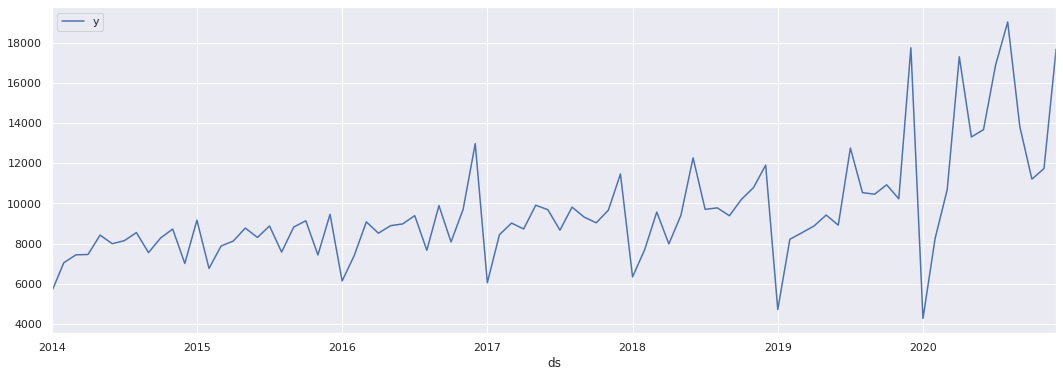

In [145]:
df_prophet_MS = pd.DataFrame(bkp_gastos_prophet, columns=['PERIODO', '36000 - Ministério da Saúde'])
df_prophet_MS.columns = ['ds','y']
df_prophet_MS.plot(x='ds',y='y',figsize=(18,6))

In [146]:
train_prophet_MS = df_prophet_MS.iloc[:60]
test_prophet_MS = df_prophet_MS.iloc[60:]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


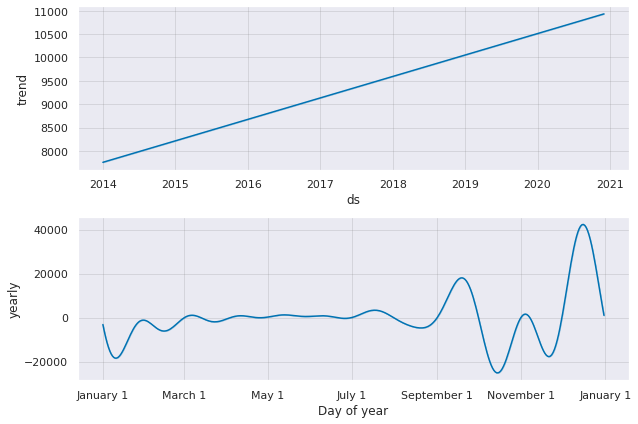

In [147]:
m = Prophet()
m.fit(train_prophet_MS)
future = m.make_future_dataframe(periods=24,freq='MS')
forecast = m.predict(future)
fig = m.plot_components(forecast)


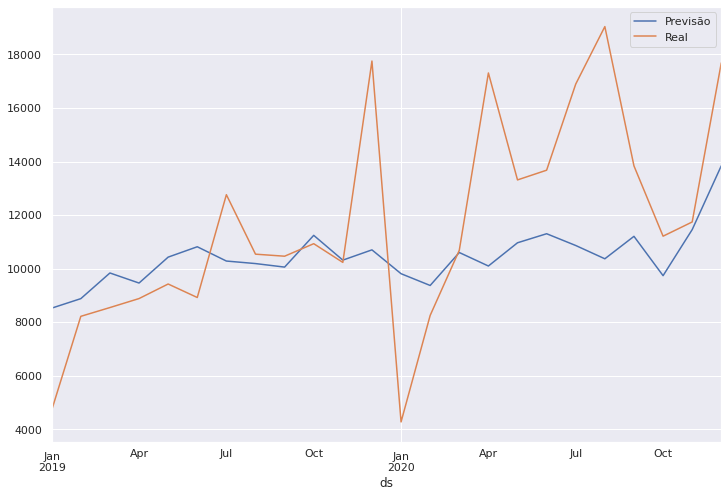

In [148]:
ax = forecast.plot(x='ds',y='yhat',label='Previsão',legend=True,figsize=(12,8))
test_prophet_MS.plot(x='ds',y='y',label='Real',legend=True,ax=ax,xlim=('2019-01-01','2020-12-01'))

In [149]:
rmse(predictions,test_prophet_MS['y'])

118865.27598137746

#####Previsão de futuro da base de despesas do Ministério da Saúde com os valores originais

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


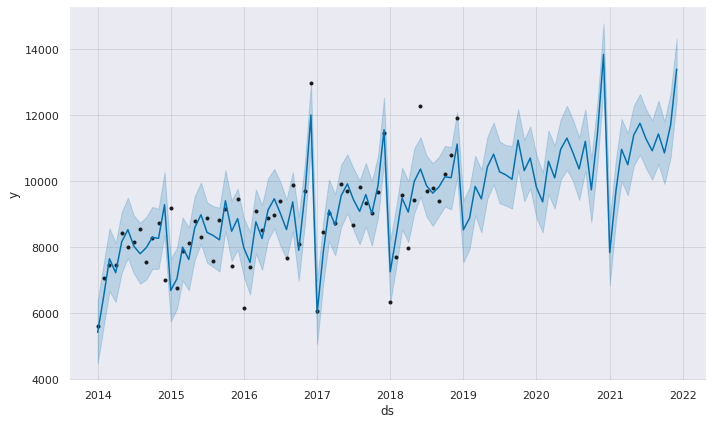

In [150]:
m = Prophet()
m.fit(train_prophet_MS)
future = m.make_future_dataframe(periods=36,freq='MS')
forecast = m.predict(future)
m.plot(forecast);

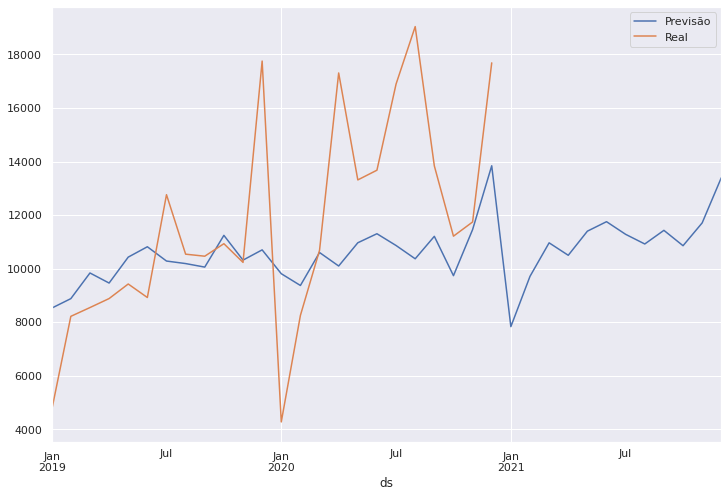

In [151]:
ax = forecast.plot(x='ds',y='yhat',label='Previsão',legend=True,figsize=(12,8))
test_prophet_MS.plot(x='ds',y='y',label='Real',legend=True,ax=ax,xlim=('2019-01-01','2021-12-01'))


##Treinando a base de despesas do Ministério da Educação com os valores originais

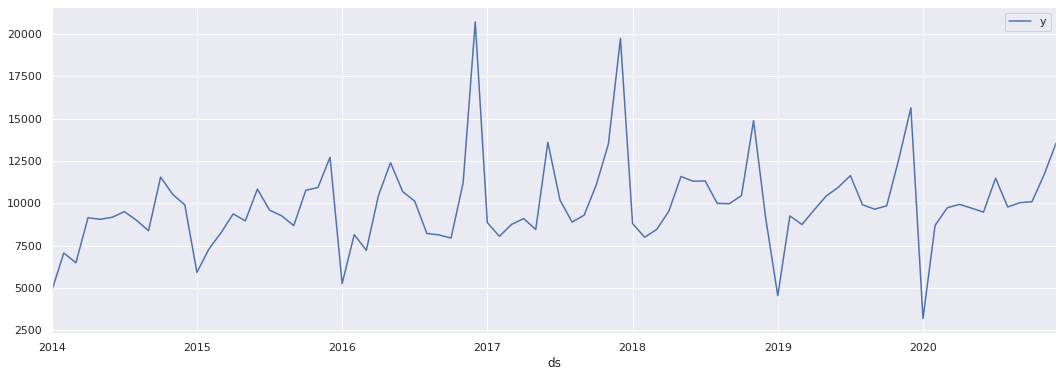

In [152]:
df_prophet_MEd = pd.DataFrame(bkp_gastos_prophet, columns=['PERIODO', '26000 - Ministério da Educação'])
df_prophet_MEd.columns = ['ds','y']
df_prophet_MEd.plot(x='ds',y='y',figsize=(18,6))

In [153]:
train_prophet_MEd = df_prophet_MEd.iloc[:60]
test_prophet_MEd = df_prophet_MEd.iloc[60:]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


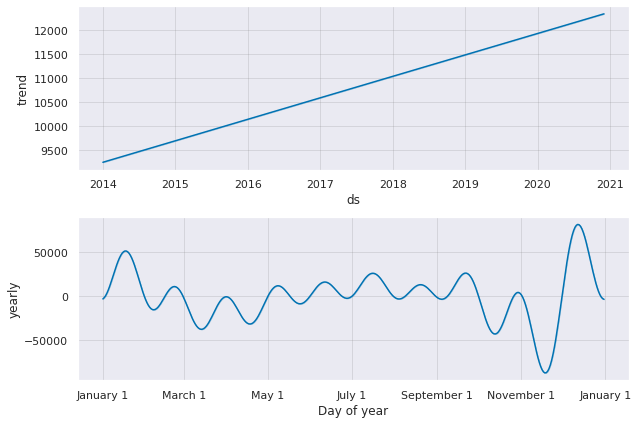

In [154]:
m = Prophet()
m.fit(train_prophet_MEd)
future = m.make_future_dataframe(periods=24,freq='MS')
forecast = m.predict(future)
fig = m.plot_components(forecast)

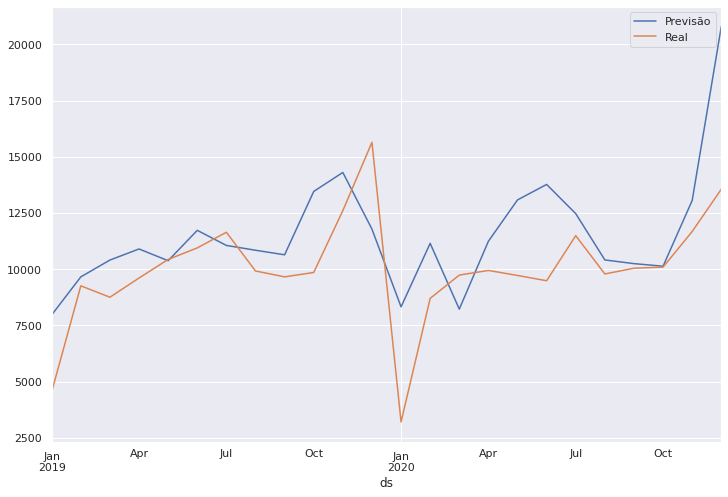

In [155]:
ax = forecast.plot(x='ds',y='yhat',label='Previsão',legend=True,figsize=(12,8))
test_prophet_MEd.plot(x='ds',y='y',label='Real',legend=True,ax=ax,xlim=('2019-01-01','2020-12-01'))

In [156]:
rmse(predictions,test_prophet_MEd['y'])

120572.2999021885

###Previsão de futuro da base de despesas do Ministério da Educação com os valores originais

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


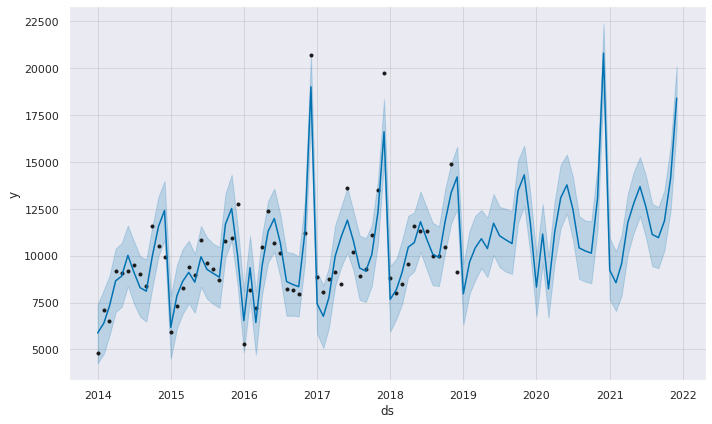

In [157]:
m = Prophet()
m.fit(train_prophet_MEd)
future = m.make_future_dataframe(periods=36,freq='MS')
forecast = m.predict(future)
m.plot(forecast);

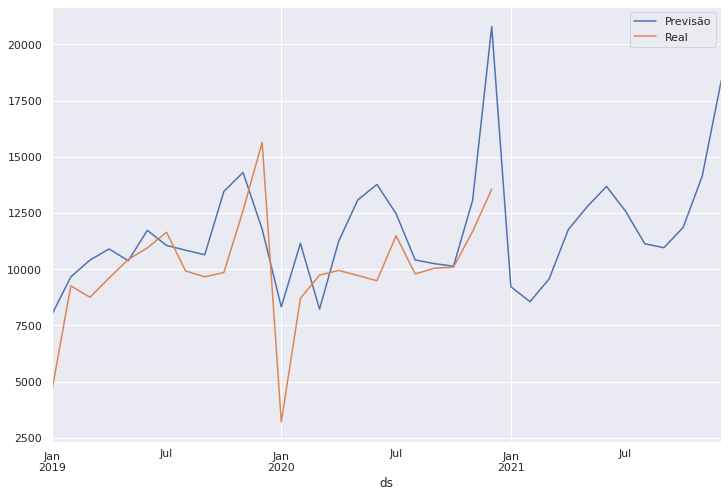

In [158]:
ax = forecast.plot(x='ds',y='yhat',label='Previsão',legend=True,figsize=(12,8))
test_prophet_MEd.plot(x='ds',y='y',label='Real',legend=True,ax=ax,xlim=('2019-01-01','2021-12-01'))